# Post Melodic Analysis
> Ignore cells 1 and 2 it's just some helpful libraries and functions that I'm pre-defining

In [1]:
from IPython.core.display import HTML
from scipy.stats import zscore
from scipy.stats import zscore
from statsmodels.formula.api import ols,mixedlm,gls
from statsmodels.stats.anova import anova_lm
import statsmodels
import natsort
import matplotlib as mpl

def multi_table(table_list):
    return HTML(
    '<table><tr style="background-color:white;">'+
    ''.join(['<td>'+table._repr_html_()+'</td>' for table in table_list])+
    '</tr></table>'
    )
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

from patsy.contrasts import ContrastMatrix

def _name_levels(prefix, levels):
    return ["[%s%s]" % (prefix, level) for level in levels]

class Simple(object):
    def _simple_contrast(self, levels):
        nlevels = len(levels)
        contr = -1./nlevels * np.ones((nlevels, nlevels-1))
        contr[1:][np.diag_indices(nlevels-1)] = (nlevels-1.)/nlevels
        return contr

    def code_with_intercept(self, levels):
        contrast = np.column_stack((np.ones(len(levels)),
                                    self._simple_contrast(levels)))
        return ContrastMatrix(contrast, _name_levels("Simp.", levels))

    def code_without_intercept(self, levels):
        contrast = self._simple_contrast(levels)
        return ContrastMatrix(contrast, _name_levels("Simp.", levels[:-1]))

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

#This should prevent text to be saved as paths making the text editable
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [2]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

# Experiment 1: (Human Connectome Data)
> [x] Organize TICA Output
>- [x] Hand Classify Components
>- [x] Make files for PALM
>- [x] Find Components that Track task
>- [ ] Find Components that Track Individual Differences


In [3]:
# Organize TICA OUTPUT
# Which Experiment Are we Analyzing
import os
import re
import pandas as pd
EXP="Exp1" #Choose "Exp1" HCP Data "Exp2" Rutgers Data  or "Exp3" NARPS Data
sub_data=pd.read_csv('Post-Melodic/Exp1/all_DesignMatrix.csv',index_col=0)
sub_data['Subject'] = 'sub-' + sub_data['Subject'].astype('int').astype('str')
sub_data['groups']=sub_data[['Dep','FamHist','HC']].idxmax(axis=1)

tica_output=[os.path.join(root,d) for root,dirs,files in os.walk("Post-Melodic/"+EXP)
             for d in dirs if ((d.endswith(".ica"))&("20dim" in d))]
sub_data.head()

Subject  Dep  FamHist   HC  Sex_demeaned  rel_mean_soc  Dep_Sx_demeaned  \
0  sub-100206  0.0      1.0  0.0     -0.569892      0.054334        -2.426523   
1  sub-100307  0.0      1.0  0.0      0.430108      0.061692        -0.426523   
2  sub-101107  0.0      1.0  0.0     -0.569892      0.081705        -0.426523   
3  sub-101915  0.0      0.0  1.0      0.430108      0.080708        -2.426523   
4  sub-102311  0.0      0.0  1.0      0.430108      0.070459        -2.426523   

   Sadness_demeaned  200_demeaned  40K_demeaned  Drinks_demeaned  \
0          7.214695     -0.181722     -0.487545        -2.344086   
1          5.614695     -0.116618     -0.226087         4.655914   
2          0.314695     -0.190316      0.046830         1.655914   
3         -5.085305      0.257861      0.385892         2.655914   
4          3.214695     -0.213363     -0.321920        -1.344086   

   Tobacco_demeaned   groups  
0         -5.688172  FamHist  
1         -5.688172  FamHist  
2         -2.688172  FamHist  
3         -5.688172       HC  
4         -5.688172       HC

In [4]:
HM_socDF=pd.read_csv('headmotion_task-SOCIAL_LT.csv')
HM_socDF['subj'] = 'sub-' + HM_socDF['subj'].astype(str)
HM_socDF=HM_socDF.rename(columns={"subj": "Subject", 
                         "abs_mean": "Soc-motion1",
                         "rel_mean": "Soc-motion2",
                         "pct_removed": "Soc-motion3"})
HM_GAMDF=pd.read_csv('headmotion_task-SOCIAL_LT.csv')
HM_GAMDF['subj'] = 'sub-' + HM_GAMDF['subj'].astype(str)
display(HM_GAMDF)
HM_GAMDF=HM_GAMDF.rename(columns={"subj": "Subject", 
                         "abs_mean": "Gam-motion1",
                         "rel_mean": "Gam-motion2",
                         "pct_removed": "Gam-motion3"})
sub_data=sub_data.merge(HM_socDF, left_on='Subject', right_on='Subject')
sub_data=sub_data.merge(HM_GAMDF, left_on='Subject', right_on='Subject')

sub_data.head()

subj  abs_mean  rel_mean  pct_removed
0    sub-445543  0.532151  0.111210     0.524359
1    sub-680250  0.251725  0.132273     0.444444
2    sub-867468  0.510002  0.141798     0.313312
3    sub-107422  0.162719  0.059799     0.322581
4    sub-101915  0.479065  0.080708     0.545455
..          ...       ...       ...          ...
286  sub-901442  0.323663  0.058302     0.431034
287  sub-910241  0.346268  0.098406     0.401882
288  sub-926862  0.728117  0.060368     0.354167
289  sub-942658  0.199816  0.065637     0.353220
290  sub-972566  0.270388  0.146862     0.529870

[291 rows x 4 columns]

Subject  Dep  FamHist   HC  Sex_demeaned  rel_mean_soc  Dep_Sx_demeaned  \
0  sub-100206  0.0      1.0  0.0     -0.569892      0.054334        -2.426523   
1  sub-100307  0.0      1.0  0.0      0.430108      0.061692        -0.426523   
2  sub-101107  0.0      1.0  0.0     -0.569892      0.081705        -0.426523   
3  sub-101915  0.0      0.0  1.0      0.430108      0.080708        -2.426523   
4  sub-102311  0.0      0.0  1.0      0.430108      0.070459        -2.426523   

   Sadness_demeaned  200_demeaned  40K_demeaned  Drinks_demeaned  \
0          7.214695     -0.181722     -0.487545        -2.344086   
1          5.614695     -0.116618     -0.226087         4.655914   
2          0.314695     -0.190316      0.046830         1.655914   
3         -5.085305      0.257861      0.385892         2.655914   
4          3.214695     -0.213363     -0.321920        -1.344086   

   Tobacco_demeaned   groups  Soc-motion1  Soc-motion2  Soc-motion3  \
0         -5.688172  FamHist     0.262308     0.054334     0.456597   
1         -5.688172  FamHist     0.332187     0.061692     0.380952   
2         -2.688172  FamHist     0.409921     0.081705     0.619262   
3         -5.688172       HC     0.479065     0.080708     0.545455   
4         -5.688172       HC     0.657729     0.070459     0.382401   

   Gam-motion1  Gam-motion2  Gam-motion3  
0     0.262308     0.054334     0.456597  
1     0.332187     0.061692     0.380952  
2     0.409921     0.081705     0.619262  
3     0.479065     0.080708     0.545455  
4     0.657729     0.070459     0.382401

### EXP1: (Human Connectome Data)
> Hand Classify Components

 31 out of 40 components in: 
  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseySubs_sm-2_merged_z.ica Output


/home/strange/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


IC  Is Good  Notes Task        stat_img  \
0  IC_01     True    NaN  Soc  _zstat1.nii.gz   

                                        path_to_stat  
0  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

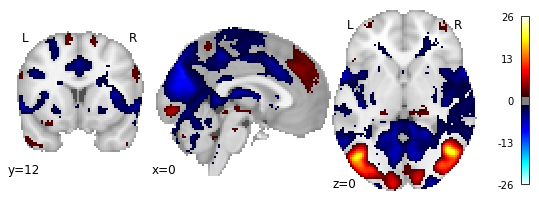

IC  Is Good  Notes Task        stat_img  \
1  IC_02     True    NaN  Soc  _zstat2.nii.gz   

                                        path_to_stat  
1  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

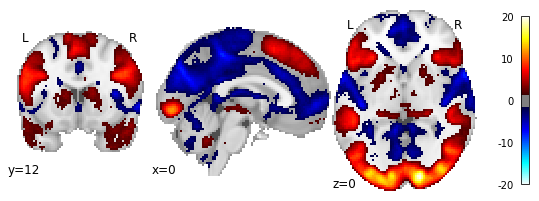

IC  Is Good  Notes Task        stat_img  \
2  IC_03     True    NaN  Soc  _zstat3.nii.gz   

                                        path_to_stat  
2  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

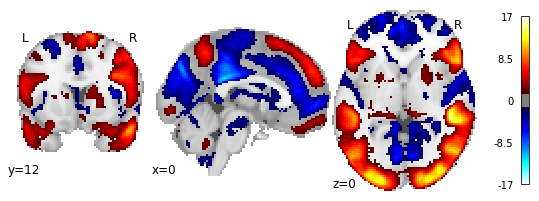

IC  Is Good  Notes Task        stat_img  \
3  IC_04     True    NaN  Soc  _zstat4.nii.gz   

                                        path_to_stat  
3  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

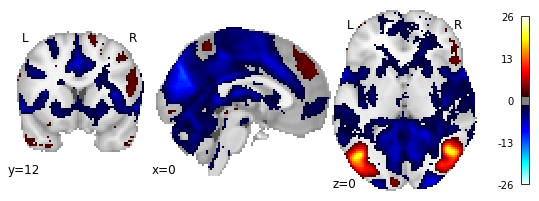

IC  Is Good  Notes Task        stat_img  \
4  IC_05     True    NaN  Soc  _zstat5.nii.gz   

                                        path_to_stat  
4  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

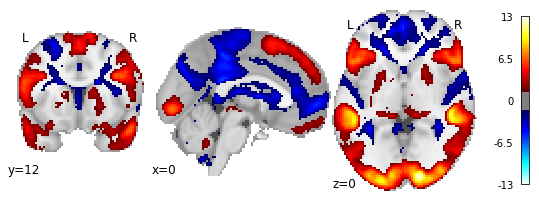

IC  Is Good  Notes Task        stat_img  \
5  IC_06     True    NaN  Soc  _zstat6.nii.gz   

                                        path_to_stat  
5  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

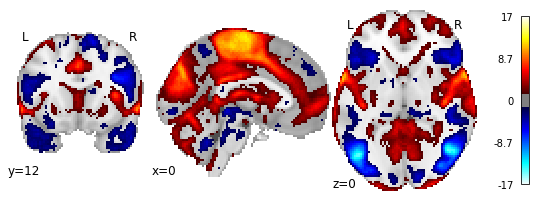

IC  Is Good  Notes Task        stat_img  \
6  IC_07     True    NaN  Soc  _zstat7.nii.gz   

                                        path_to_stat  
6  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

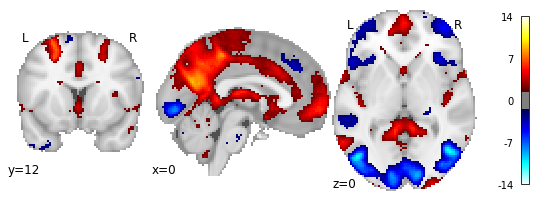

IC  Is Good  Notes Task        stat_img  \
7  IC_08     True    NaN  Soc  _zstat8.nii.gz   

                                        path_to_stat  
7  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

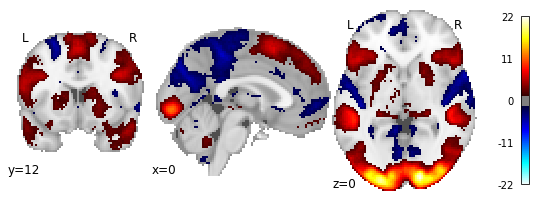

IC  Is Good  Notes Task        stat_img  \
8  IC_09    False    NaN  Soc  _zstat9.nii.gz   

                                        path_to_stat  
8  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

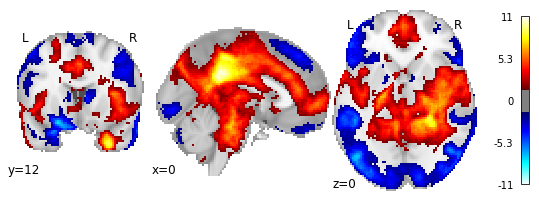

IC  Is Good  Notes Task         stat_img  \
9  IC_10     True    NaN  Soc  _zstat10.nii.gz   

                                        path_to_stat  
9  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

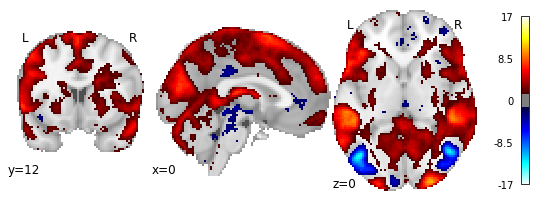

IC  Is Good  Notes Task         stat_img  \
10  IC_11     True    NaN  Soc  _zstat11.nii.gz   

                                         path_to_stat  
10  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

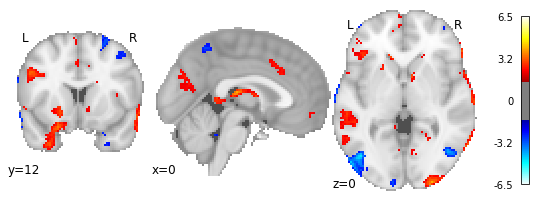

IC  Is Good  Notes Task         stat_img  \
11  IC_12     True    NaN  Soc  _zstat12.nii.gz   

                                         path_to_stat  
11  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

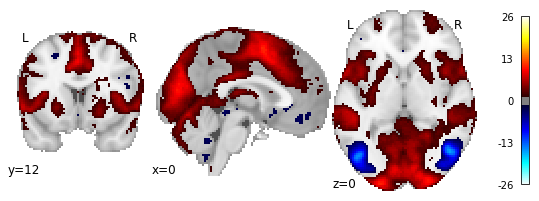

IC  Is Good  Notes Task         stat_img  \
12  IC_13     True    NaN  Soc  _zstat13.nii.gz   

                                         path_to_stat  
12  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

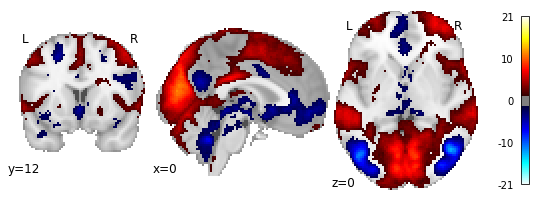

IC  Is Good  Notes Task         stat_img  \
13  IC_14    False    NaN  Soc  _zstat14.nii.gz   

                                         path_to_stat  
13  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

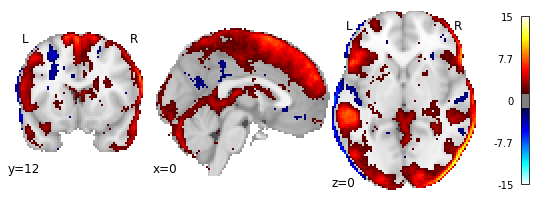

IC  Is Good  Notes Task         stat_img  \
14  IC_15     True    NaN  Soc  _zstat15.nii.gz   

                                         path_to_stat  
14  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

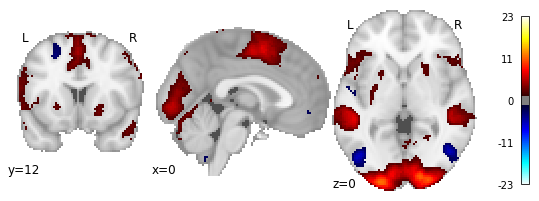

IC  Is Good  Notes Task         stat_img  \
15  IC_16     True    NaN  Soc  _zstat16.nii.gz   

                                         path_to_stat  
15  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

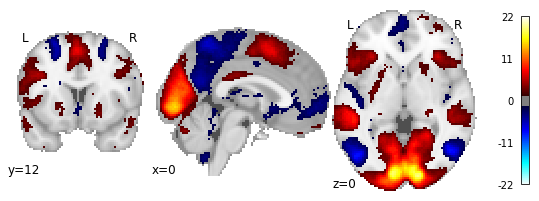

IC  Is Good  Notes Task         stat_img  \
16  IC_17     True    NaN  Soc  _zstat17.nii.gz   

                                         path_to_stat  
16  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

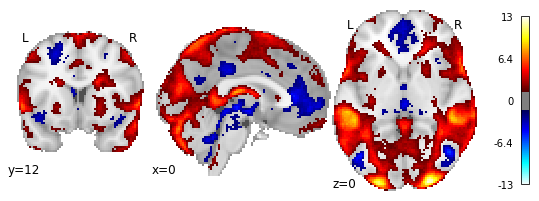

IC  Is Good  Notes Task         stat_img  \
17  IC_18     True    NaN  Soc  _zstat18.nii.gz   

                                         path_to_stat  
17  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

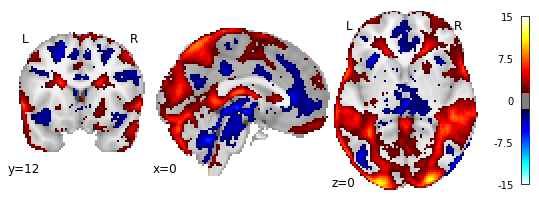

IC  Is Good  Notes Task         stat_img  \
18  IC_19    False    NaN  Soc  _zstat19.nii.gz   

                                         path_to_stat  
18  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

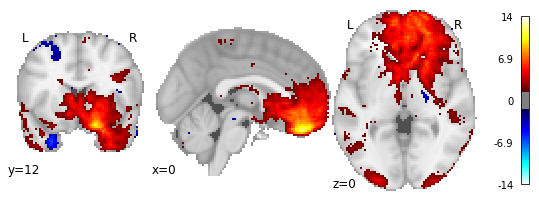

IC  Is Good  Notes Task         stat_img  \
19  IC_20    False    NaN  Soc  _zstat20.nii.gz   

                                         path_to_stat  
19  Post-Melodic/Exp1/tica_20dim_task-Soc_LindseyS...

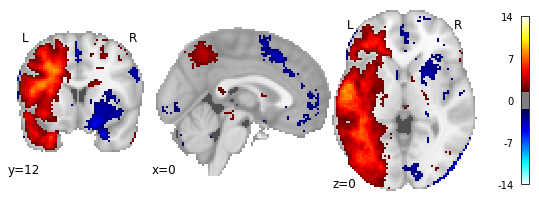

IC  Is Good  Notes Task        stat_img  \
0  IC_01     True    NaN  Gam  _zstat1.nii.gz   

                                        path_to_stat  
0  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

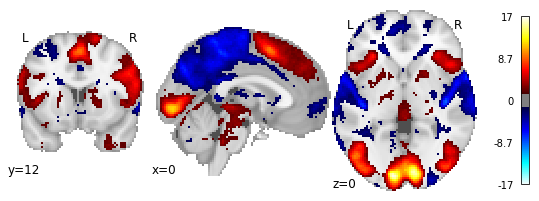

IC  Is Good  Notes Task        stat_img  \
1  IC_02     True    NaN  Gam  _zstat2.nii.gz   

                                        path_to_stat  
1  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

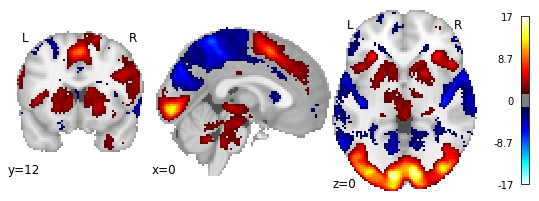

IC  Is Good  Notes Task        stat_img  \
2  IC_03     True    NaN  Gam  _zstat3.nii.gz   

                                        path_to_stat  
2  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

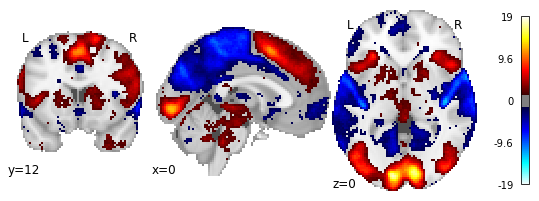

IC  Is Good  Notes Task        stat_img  \
3  IC_04     True    NaN  Gam  _zstat4.nii.gz   

                                        path_to_stat  
3  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

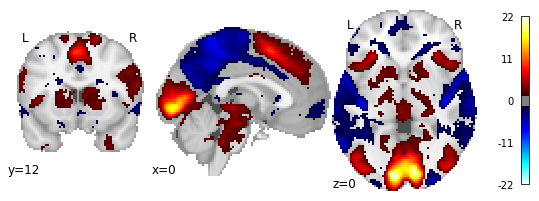

IC  Is Good  Notes Task        stat_img  \
4  IC_05     True    NaN  Gam  _zstat5.nii.gz   

                                        path_to_stat  
4  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

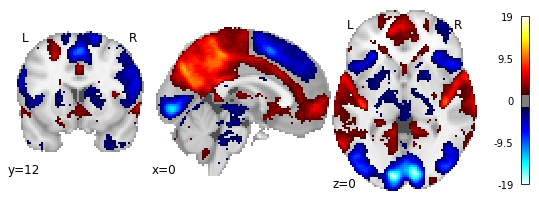

IC  Is Good  Notes Task        stat_img  \
5  IC_06     True    NaN  Gam  _zstat6.nii.gz   

                                        path_to_stat  
5  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

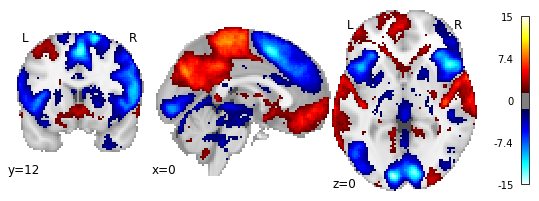

IC  Is Good  Notes Task        stat_img  \
6  IC_07     True    NaN  Gam  _zstat7.nii.gz   

                                        path_to_stat  
6  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

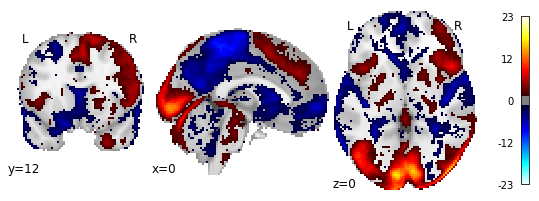

IC  Is Good  Notes Task        stat_img  \
7  IC_08     True    NaN  Gam  _zstat8.nii.gz   

                                        path_to_stat  
7  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

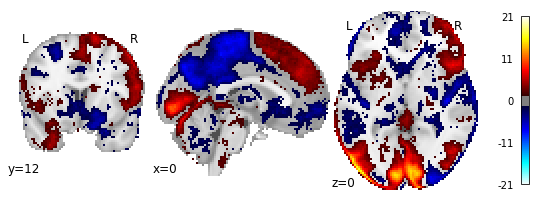

IC  Is Good  Notes Task        stat_img  \
8  IC_09     True    NaN  Gam  _zstat9.nii.gz   

                                        path_to_stat  
8  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

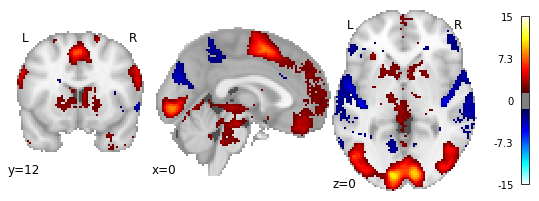

IC  Is Good  Notes Task         stat_img  \
9  IC_10    False    NaN  Gam  _zstat10.nii.gz   

                                        path_to_stat  
9  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

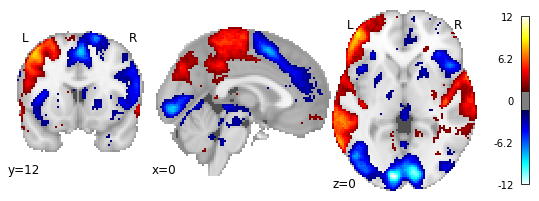

IC  Is Good  Notes Task         stat_img  \
10  IC_11     True    NaN  Gam  _zstat11.nii.gz   

                                         path_to_stat  
10  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

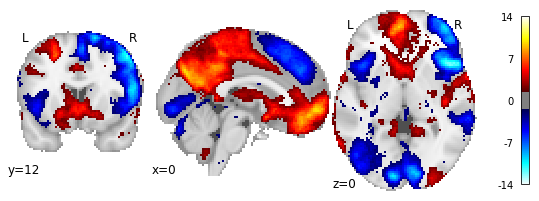

IC  Is Good  Notes Task         stat_img  \
11  IC_12     True    NaN  Gam  _zstat12.nii.gz   

                                         path_to_stat  
11  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

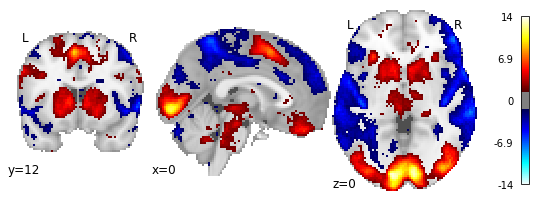

IC  Is Good  Notes Task         stat_img  \
12  IC_13     True    NaN  Gam  _zstat13.nii.gz   

                                         path_to_stat  
12  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

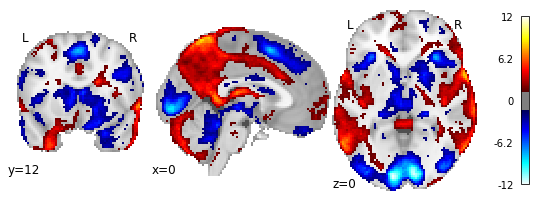

IC  Is Good  Notes Task         stat_img  \
13  IC_14    False    NaN  Gam  _zstat14.nii.gz   

                                         path_to_stat  
13  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

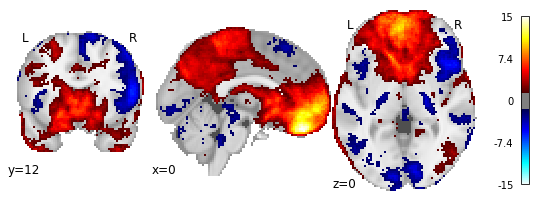

IC  Is Good  Notes Task         stat_img  \
14  IC_15     True    NaN  Gam  _zstat15.nii.gz   

                                         path_to_stat  
14  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

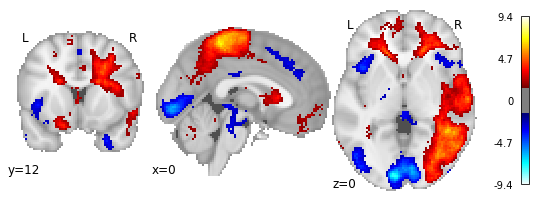

IC  Is Good  Notes Task         stat_img  \
15  IC_16    False    NaN  Gam  _zstat16.nii.gz   

                                         path_to_stat  
15  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

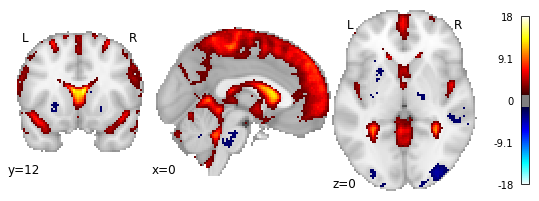

IC  Is Good  Notes Task         stat_img  \
16  IC_17     True    NaN  Gam  _zstat17.nii.gz   

                                         path_to_stat  
16  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

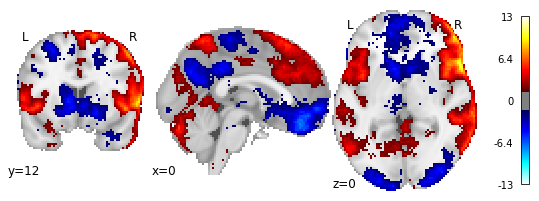

IC  Is Good  Notes Task         stat_img  \
17  IC_18     True    NaN  Gam  _zstat18.nii.gz   

                                         path_to_stat  
17  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

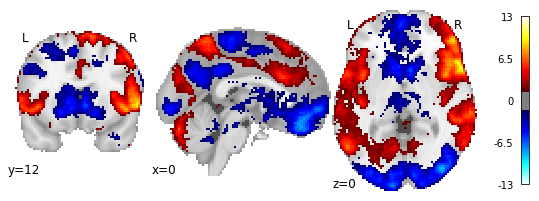

IC  Is Good  Notes Task         stat_img  \
18  IC_19    False    NaN  Gam  _zstat19.nii.gz   

                                         path_to_stat  
18  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

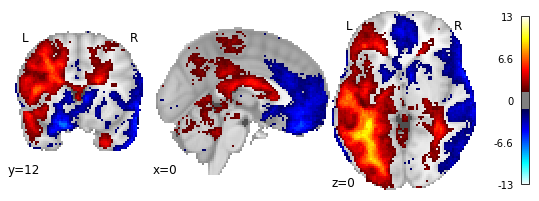

IC  Is Good  Notes Task         stat_img  \
19  IC_20    False    NaN  Gam  _zstat20.nii.gz   

                                         path_to_stat  
19  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...

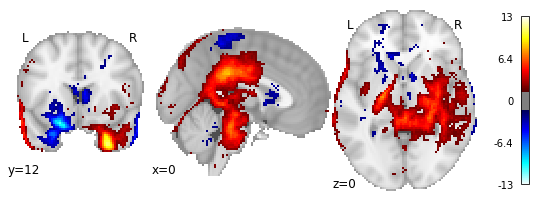

In [5]:
# Hand Classify Components
import nilearn.plotting
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt

hand_class=[]
for out in tica_output:
    file=[out+'/'+fname for fname in os.listdir(out) if 'Classified' in fname][0]
    task=re.search("task-(.*?)_",out).group(1) 
    statimages=natsorted([os.path.join(root,f) for root,dirs,files in os.walk(out)
             for f in files if f.startswith("thresh_zstat")])
    tmp=pd.read_csv(file)
    tmp['Task']=task
    tmp['stat_img']=[re.search("thresh(.*)",img).group(1) for img in statimages]
    tmp['path_to_stat']=statimages
    
    hand_class.append(tmp)
hand_class=pd.concat(hand_class)
hand_class_plt=hand_class.copy()

print(color.BOLD+" %s out of %s "%(len(hand_class[hand_class['Is Good']==True])
                                   ,len(hand_class))+color.END+"components in: \n  %s Output"%(out))

for img in hand_class['path_to_stat']:
    display(hand_class[hand_class['path_to_stat']==img])
    nilearn.plotting.plot_stat_map(img,cut_coords=[0,12,0],draw_cross=False,threshold=1.5)
    plt.show()


### Exp1: (Human Connectome Data)
> If you want an interactive map for more spatial detail name it in the cell below:
>- Warning variables get renamed in Exp2 so run cells in order

IC  Is Good  Notes Task        stat_img  \
0  IC_01     True    NaN  Gam  _zstat1.nii.gz   

                                        path_to_stat  
0  Post-Melodic/Exp1/tica_20dim_task-Gam_LindseyS...


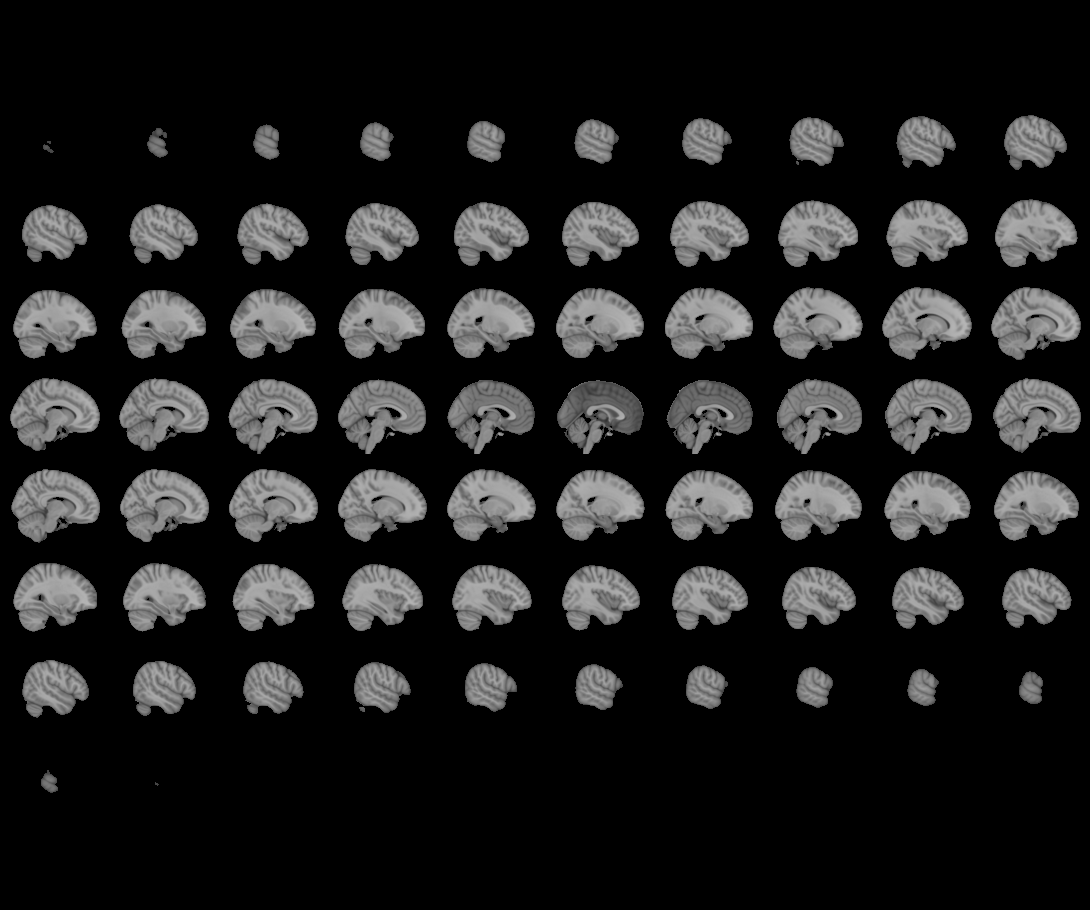
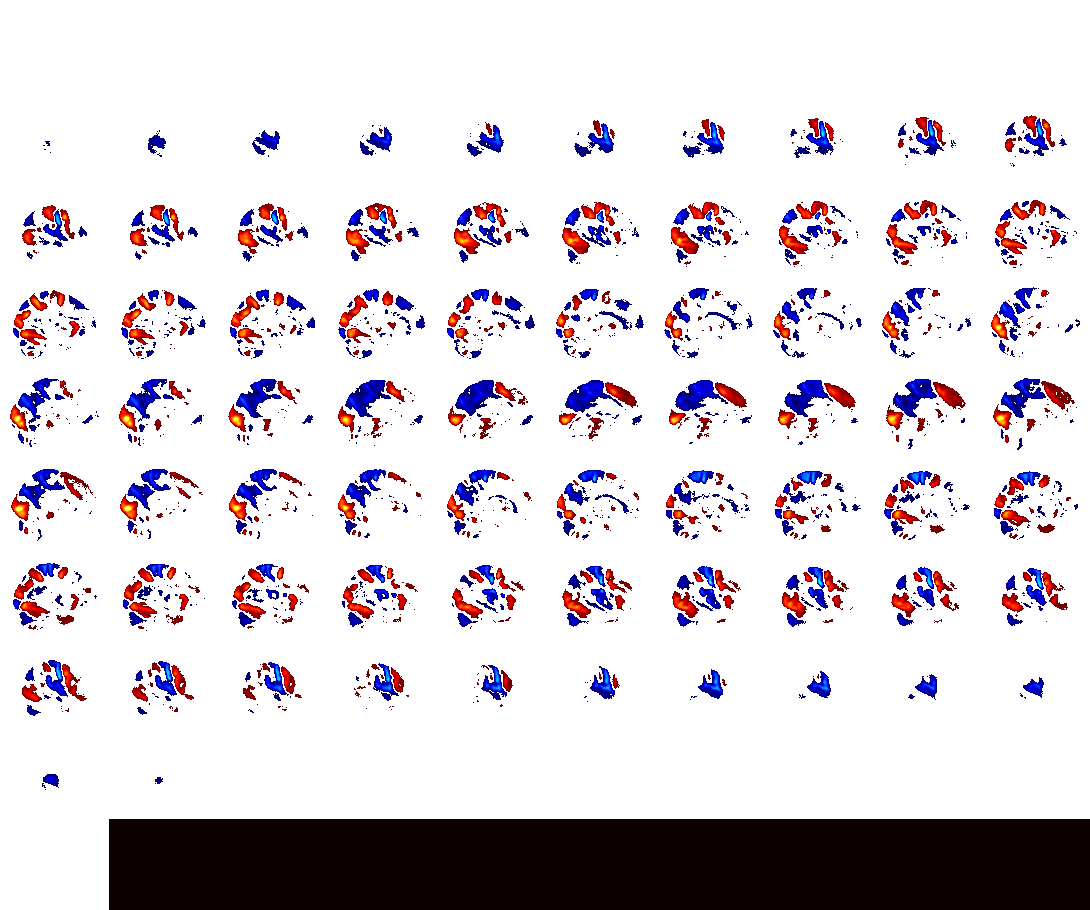

In [6]:
#Us the name from the output under IC bellow
IWantABetterLookAt,task="IC_01","Gam"
row=hand_class[(hand_class['IC']==IWantABetterLookAt)&
               (hand_class['Task']==task)].copy()
fname=row['path_to_stat'].iloc[0]
display(row)
nilearn.plotting.view_img(fname,draw_cross=False,title=IWantABetterLookAt)

### Exp1: (Human Connectome Data)
> Make PALM Files

| Subject Mode      | Temporal Mode Fit  |             
|:------------|:---------------|
|<ul><li> Gamble Task &check; | <ul><li> Gamble Task &check;|
|<ul><li> Social Task  &check; | <ul><li> Social Task &check;|


In [7]:
##################___________Make PALM FILES____________##############

reg_list=[]
for results in tica_output: # Experiment 1 has 2 tasks to deal with.
    print(results)
    task=re.search('task-(.*?)_',results).group(1)
    handclass=hand_class[hand_class['Task']==task].copy()

    #Get subject number in order from tica logfiles___________________________________
    log_file = open(results+'/log.txt', 'r') 
    Lines = log_file.readlines()
    log_file.close()
    subs=[]
    for line in Lines:
        if line.startswith("Excluding voxels with constant value"):
            break
        elif line.startswith("Reading data file"):
            subs.append('sub-'+re.search('sub-(.*)_task',line).group(1))
            
#SUBJECT MODE ________________________________________________________________________

    #Import Smodes Name Columns add Subject numbers and get rid of noise components
    # We don't skip anyrows for this file
    smodes=pd.read_csv(results+'/melodic_Smodes',
                       delim_whitespace=True,header=None)#,skiprows=1
    colnames=['IC_%02d'%(i+1) for i,col in enumerate(smodes.columns)]#give columns names
    smodes.columns=colnames
    smodes['Subject']=subs #add subject number
    smode_df=smodes.copy()
    smode_df.to_csv(
        'Post-Melodic/Code/PALM/Exp1/Smode_wHeader_%s_task-%s_.csv'%(EXP,task),index=False)
    drop_columns=[IC for IC in handclass[handclass['Is Good']==False]['IC'].values]
    drop_columns.append('Subject')
    smodes.drop(columns=drop_columns).to_csv(
        'Post-Melodic/Code/PALM/Exp1/ForPALM_%s_task-%s_smode.csv'%(EXP,task),header=False,index=False)

#Temporal Mode________________________________________________________________________    
    #1.) Organize task information 
    
    design_df=[]
    for run in ['LR','RL']: #Both Runs of Info get concatonated but different columnnames
        if task=='Gam':
            tmp=pd.read_csv('Post-Melodic/Exp1/L1_task-%s_run-%s_design.mat'%(task,run),skiprows=5,sep='\t',
                       header=None,names=['Gains','Losses','DropThis'])
            tmp=tmp[['Gains','Losses']]
            design_df.append(tmp.copy())
        if task=='Soc':
            tmp=pd.read_csv('Post-Melodic/Exp1/L1_task-%s_run-%s_design.mat'%(task,run),skiprows=5,sep='\t',
                       header=None,names=['Mental','non_social','DropThis'])
            tmp=tmp[['Mental','non_social']]
            design_df.append(tmp.copy())
            
    design_df=pd.concat(design_df)
    
    # 2.) Get the temporal mode info
    # 2.) a. Get a list of the tmode files from the report section
    files=[results+'/report/'+f for f in os.listdir(results+'/report/') if f.startswith('t') if f.endswith('.txt')]
    
    df_list=[]
    #2.) b. Attach Temporal mode to subject and group Should be same order as going in 
            # minus the first row which is the mean
    for row in sub_data.iterrows():
        #display(row[1])
        tdf=design_df
        tdf['sub']=row[1]['Subject']
        tdf['group']=row[1]['groups']
        df_list.append(tdf.copy())

    tmode_df=pd.concat(df_list).reset_index(drop=True)
    # 2.) c. Read temporal weights and zscore them
    for f in natsorted(files):

        Tweight_df=pd.read_csv(f,delim_whitespace=True,
                               header=None,names=subs)
        Tweight_df.reset_index(drop=True,inplace=True)
        Zweight_df=Tweight_df.apply(zscore)
        tmode_df['IC_%02d'%(int(
            re.search('report/t(.*).txt',f).group(1)))]=Zweight_df.melt()['value']
    tmode_df.to_csv(
        'Post-Melodic/Code/PALM/Exp1/Tmodes-Unfit_task-%s.csv'%(task))
    
    # 3.) Running a regression on the temporal mode for each subject
    data=[]
    if task== 'Soc':
        conditions=['Mental','non_social']
    elif task=='Gam':
        conditions=['Gains','Losses']

    for IC in handclass['IC'].values:
        row=[]
        for sub in natsorted(tmode_df['sub'].unique()):
            t_df=tmode_df[tmode_df['sub']==sub].copy()
            e1="%s ~ %s + %s"%(IC,conditions[0],conditions[1])
            model1 = gls(e1, t_df).fit()
            row.append([sub,t_df.group.unique()[0],
                        IC,model1.params[conditions[0]],
                        model1.params[conditions[1]]])
        row=np.array(row)
        data.append(row)
        
# Prepare Data for PALM__________________________________________________________________    
    reg_df=pd.DataFrame(columns=['sub','group','IC',conditions[0],conditions[1]],
                        data=np.concatenate(data))
    reg_df[conditions[0]]=pd.to_numeric(reg_df[conditions[0]])
    reg_df[conditions[1]]=pd.to_numeric(reg_df[conditions[1]])
    reg_df['Diff']=reg_df[conditions[0]]-reg_df[conditions[1]]
    reg_df['Task']=task
    
    reg_list.append(reg_df.copy())
    pivot_df=reg_df[['sub','IC','Diff']]
    pivot_df=pivot_df.pivot('sub','IC')
    columns=[item for item in handclass[handclass['Is Good']==True].IC.values]
    pivot_df=pivot_df['Diff'][columns]

    pivot_df.to_csv('Post-Melodic/Code/PALM/Exp1/Fit_T_beta-Diff_task-%s.csv'%(task),
                    index=False,header=False)
    pivot_df.to_csv('Post-Melodic/Code/PALM/Exp1/Fit_T_beta_withHeader-Diff_task-%s.csv'%(task),
                    index=False)
    pivot_df.to_csv('Post-Melodic/Code/PALM/Exp1/Fit_T_beta-Diff_task-%s.csv'%(task),
                    index=False,header=False)
    pivot_df.to_csv('Post-Melodic/Code/PALM/Exp1/Fit_T_beta_withHeader-Diff_task-%s.csv'%(task),
                    index=False)
    display(pivot_df)
reg_df=pd.concat(reg_list)
    

Post-Melodic/Exp1/tica_20dim_task-Soc_LindseySubs_sm-2_merged_z.ica


IC             IC_01     IC_02     IC_03     IC_04     IC_05     IC_06  \
sub                                                                      
sub-100206 -0.035203  0.220839  0.432527  0.061525  0.400141 -0.306337   
sub-100307 -0.150916  0.110658  0.211913 -0.106518  0.079321 -0.236595   
sub-101107  0.060485 -0.164087 -0.039478  0.300188 -0.365103 -0.653055   
sub-101915  0.091599  0.336986  0.529250  0.193124  0.538496 -0.308574   
sub-102311  0.109730  0.522761  0.832245  0.332206  0.796571 -0.793770   
...              ...       ...       ...       ...       ...       ...   
sub-973770 -0.161916  0.268233  0.087029 -0.238023  0.364525 -0.296004   
sub-978578  0.619891  0.940433  1.367098  0.768239  1.334136 -0.965343   
sub-991267 -0.130696  0.143439  0.481641  0.015591  0.389779 -0.355251   
sub-993675 -0.213557  0.032048  0.418953 -0.050827  0.323579 -0.167708   
sub-996782 -0.075398  0.368028  0.563996  0.034073  0.657410 -0.325540   

IC             IC_07     IC_08     IC_10     IC_11     IC_12     IC_13  \
sub                                                                      
sub-100206  0.171936  0.293653  0.296408  0.294913 -0.140161 -0.398137   
sub-100307  0.232381  0.153454  0.248615  0.129626 -0.179395 -0.185776   
sub-101107 -0.380288 -0.202197 -0.850961 -0.383079 -0.914483 -0.566016   
sub-101915 -0.131886  0.364644  0.249965 -0.009074 -0.028441 -0.096718   
sub-102311 -0.086500  0.562976  0.400168  0.123554 -0.111457 -0.327674   
...              ...       ...       ...       ...       ...       ...   
sub-973770 -0.060307  0.367662  0.402109  0.617564  0.115904  0.053299   
sub-978578 -0.414696  0.958573  0.050860 -0.479227 -0.365368 -0.608835   
sub-991267  0.457406  0.167059  0.620306  0.512249 -0.200081 -0.442922   
sub-993675  0.485017  0.055918  0.612661  0.657849 -0.233754 -0.499046   
sub-996782  0.065930  0.526308  0.374488  0.214581 -0.129003 -0.221817   

IC             IC_15     IC_16     IC_17     IC_18  
sub                                                 
sub-100206  0.156504 -0.026690  0.329979  0.216263  
sub-100307 -0.107342 -0.099266  0.298237  0.060911  
sub-101107 -0.798700 -0.551571 -0.216812 -0.096039  
sub-101915  0.238819  0.087162  0.660309  0.467006  
sub-102311  0.281505  0.185498  0.397990  0.259409  
...              ...       ...       ...       ...  
sub-973770  0.179302  0.544474  0.222789 -0.334952  
sub-978578  0.441795  0.050192  0.590375  0.486398  
sub-991267 -0.033085 -0.125826  0.493047  0.194056  
sub-993675 -0.103082 -0.399536  0.464400  0.010295  
sub-996782  0.207208  0.277630  0.721404  0.196124  

[279 rows x 16 columns]

Post-Melodic/Exp1/tica_20dim_task-Gam_LindseySubs_sm-2_merged_z.ica


IC             IC_01     IC_02     IC_03     IC_04     IC_05     IC_06  \
sub                                                                      
sub-100206  0.134337  0.138533  0.107021  0.087614 -0.098894 -0.158968   
sub-100307  0.289155  0.245207  0.268953  0.252810 -0.251811 -0.335730   
sub-101107  0.013967  0.168746  0.318629 -0.002815 -0.358813 -0.090692   
sub-101915  0.208149  0.225361  0.291316  0.145487 -0.228499 -0.395448   
sub-102311 -0.077370 -0.119772 -0.166917 -0.077090  0.116367 -0.035399   
...              ...       ...       ...       ...       ...       ...   
sub-973770  0.199518  0.279096  0.271370  0.313357 -0.279221 -0.145832   
sub-978578  0.027115 -0.038733 -0.086849  0.064364  0.025143 -0.003996   
sub-991267  0.138705  0.167764  0.255064  0.137500 -0.277536 -0.076283   
sub-993675 -0.154990 -0.224753 -0.208348 -0.269003  0.261671  0.180034   
sub-996782  0.181928  0.193808  0.197373  0.155388 -0.149829 -0.186943   

IC             IC_07     IC_08     IC_09     IC_11     IC_12     IC_13  \
sub                                                                      
sub-100206  0.066422  0.213910  0.095473 -0.179986  0.020341 -0.052924   
sub-100307  0.164929  0.226435  0.257811 -0.334191  0.246056 -0.229342   
sub-101107 -0.054909 -0.098318  0.120175 -0.029822  0.117083 -0.322046   
sub-101915  0.224578  0.204716  0.135414 -0.381134  0.116065 -0.092238   
sub-102311 -0.034347  0.011982 -0.084914 -0.053686 -0.192929  0.109224   
...              ...       ...       ...       ...       ...       ...   
sub-973770  0.115690  0.058453  0.126586 -0.113211  0.310548 -0.313393   
sub-978578  0.185265 -0.389691  0.304650  0.236793  0.185795  0.018376   
sub-991267  0.077938  0.044994  0.126668 -0.123205  0.245729 -0.148030   
sub-993675 -0.163579 -0.354199 -0.211008  0.080168 -0.169011  0.270399   
sub-996782  0.035315  0.228841  0.218323 -0.019926  0.300108 -0.092014   

IC             IC_15     IC_17     IC_18  
sub                                       
sub-100206 -0.203995  0.217527  0.244442  
sub-100307 -0.188904  0.268153  0.240242  
sub-101107 -0.134690 -0.498194 -0.338399  
sub-101915 -0.191323  0.486587  0.414468  
sub-102311  0.277203  0.323121  0.401347  
...              ...       ...       ...  
sub-973770 -0.574544 -0.181555 -0.484970  
sub-978578  0.233097 -0.338043 -0.040588  
sub-991267 -0.139968 -0.219964 -0.374834  
sub-993675  0.342936  0.123461  0.127037  
sub-996782  0.259544 -0.020594  0.027114  

[279 rows x 15 columns]

In [8]:
smodes

IC_01     IC_02     IC_03     IC_04     IC_05     IC_06     IC_07  \
0    8.749892  8.055666  7.690053  8.381572  7.752454  7.968712  8.687254   
1    7.389123  7.577610  6.963301  7.911806  7.416806  6.171193  8.061034   
2    5.108032  5.622368  4.772856  5.162784  4.842455  5.072304  5.523733   
3    7.629064  7.495881  7.349029  7.986473  7.349370  6.518744  7.002798   
4    7.875955  8.107708  7.453491  8.021506  7.700925  8.237094  8.372751   
..        ...       ...       ...       ...       ...       ...       ...   
274  5.597872  6.649579  6.136732  4.874520  5.701403  6.915062  6.172144   
275  6.733943  6.423993  6.533772  6.967843  6.537740  6.544332  5.657610   
276  6.256385  6.583316  6.339014  6.206639  6.107369  6.314388  6.197076   
277  4.825580  4.661942  4.513089  4.919668  4.921066  3.755985  4.727599   
278  7.079131  6.461682  6.953532  6.188148  6.924012  7.362974  6.607546   

        IC_08     IC_09     IC_10  ...     IC_12     IC_13     IC_14  \
0    9.689806  7.732840  7.661254  ...  6.640476  6.958853  5.244863   
1    8.170964  6.435417  6.405987  ...  6.460789  6.452767  5.445334   
2    4.774644  5.427441  4.555600  ...  4.422364  3.880184  4.576921   
3    6.942915  7.795420  5.591868  ...  7.396835  6.119412  3.703847   
4    8.131153  6.179876  7.618779  ...  6.365167  7.052813  7.352027   
..        ...       ...       ...  ...       ...       ...       ...   
274  5.293034  5.412175  6.777700  ...  4.392696  5.251273  5.507644   
275  5.507224  6.604741  6.478084  ...  6.810118  6.532657  5.368738   
276  6.412915  5.008149  5.432664  ...  4.840781  5.903984  5.474010   
277  5.848605  4.373287  2.999092  ...  3.443403  3.724276  2.845429   
278  6.939272  6.946267  5.889294  ...  5.367854  5.249879  4.862750   

        IC_15     IC_16     IC_17     IC_18     IC_19     IC_20     Subject  
0    5.996248  3.906816  5.752390  3.150395  2.358674  1.699953  sub-100206  
1    5.602763  5.624537  1.642931  1.534448  0.880710 -0.497820  sub-100307  
2    4.537556  3.825930  1.599899  0.653298  0.589214 -1.330539  sub-101107  
3    6.575240  4.576006  0.826294  1.703819  0.443284 -0.291295  sub-101915  
4    5.746881  7.553774  6.719877  4.130379  0.736764 -0.630018  sub-102311  
..        ...       ...       ...       ...       ...       ...         ...  
274  3.497532  2.461218  3.329254  1.453981  0.227108 -0.566464  sub-973770  
275  5.554917  3.255939  1.381391  2.011577  0.331872 -1.895372  sub-978578  
276  5.220628  3.770052  2.808498  1.557210  0.633985  1.502252  sub-991267  
277  2.884108  2.404273  1.502515  0.574322  1.168460 -0.069688  sub-993675  
278  5.805411  3.856478  4.161777  2.018384 -1.939525 -2.535423  sub-996782  

[279 rows x 21 columns]

In [9]:
columns

['IC_01',
 'IC_02',
 'IC_03',
 'IC_04',
 'IC_05',
 'IC_06',
 'IC_07',
 'IC_08',
 'IC_09',
 'IC_11',
 'IC_12',
 'IC_13',
 'IC_15',
 'IC_17',
 'IC_18']

### Experiment 1: HCP Data
> Run PALM on Both Tasks

In [10]:
if 1==0:
    Input='Post-Melodic/Code/PALM/Exp1/Fit_T_beta-Diff_task-Soc.csv'
    Output='Post-Melodic/Code/PALM/Exp1/Soc-task_results/'
    #!./palm-alpha118/palm -i $Input -o $Output -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/Exp1/Fit_T_beta-Diff_task-Gam.csv'
    Output='Post-Melodic/Code/PALM/Exp1/Gam-task_results/'
    #!./palm-alpha118/palm -i $Input -o $Output -twotail -quiet -fdr
    
    Input='Post-Melodic/Code/PALM/Exp1/Fit_T_beta-Diff_task-Soc.csv'
    Output='Post-Melodic/Code/PALM/Exp1/Soc-DEPTASK_results/'
    !./palm-alpha118/palm -i $Input -o $Output -d design.mat -t design.con  -eb EB.csv -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/Exp1/Fit_T_beta-Diff_task-Gam.csv'
    Output='Post-Melodic/Code/PALM/Exp1/Gam-DEPTASK_results/'
    !./palm-alpha118/palm -i $Input -o $Output -d design.mat -t design.con  -eb EB.csv -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/Exp1/ForPALM_Exp1_task-Soc_smode.csv'
    Output='Post-Melodic/Code/PALM/Exp1/Soc-Depression_results/'
    !./palm-alpha118/palm -i $Input -o $Output -d design.mat -t design.con  -eb EB.csv -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/Exp1/ForPALM_Exp1_task-Gam_smode.csv'
    Output='Post-Melodic/Code/PALM/Exp1/Gam-Depression_results/'
    !./palm-alpha118/palm -i $Input -o $Output -d design.mat -t design.con  -eb EB.csv -twotail -quiet -fdr

In [11]:
palm_list=[]
print([i for i in os.listdir('Post-Melodic/Code/PALM/Exp1') if 'results' in i])
for task in ['Gam','Soc']:
    handclass=hand_class[hand_class['Task']==task].copy()
    names=[IC for IC in handclass[handclass['Is Good']==True]['IC']]
    palm_df=[]
    Output='Post-Melodic/Code/PALM/Exp1/%s-task_results/'%(task)
    for f in [Output+f for f in os.listdir(Output) if 'tstat' in f]:
        t=pd.read_csv(f,names=names)
        t['file']=re.search('tstat(.*)',f).group(0)
        palm_df.append(t)
    palm_df=pd.concat(palm_df)
    palm_df['Task']=task
    palm_list.append(palm_df.melt(id_vars=['file','Task'],var_name='IC',value_name='stat'))
palm_df=pd.concat(palm_list)
display(palm_df)

['Gam-DEPTASK_results', 'Soc-DEPTASK_results', 'Gam-task_results', 'Gam-Depression_results', 'Soc-task_results', 'Soc-Depression_results']


file Task     IC    stat
0    tstat_fdrp_c1.csv  Gam  IC_01  0.0001
1    tstat_uncp_c1.csv  Gam  IC_01  0.0001
2    tstat_fwep_c1.csv  Gam  IC_01  0.0001
3    tstat_fwep_c2.csv  Gam  IC_01  0.0001
4    tstat_fdrp_c2.csv  Gam  IC_01  0.0001
..                 ...  ...    ...     ...
123  tstat_fwep_c2.csv  Soc  IC_18  0.0001
124  tstat_fdrp_c2.csv  Soc  IC_18  0.0001
125       tstat_c1.csv  Soc  IC_18  5.3361
126  tstat_uncp_c2.csv  Soc  IC_18  0.0001
127       tstat_c2.csv  Soc  IC_18 -5.3361

[248 rows x 4 columns]

### Experiment 1: (Human Connectome)
> Quick Display Of Results

file Task     IC    stat
0  tstat_fdrp_c1.csv  Gam  IC_01  0.0001
1  tstat_uncp_c1.csv  Gam  IC_01  0.0001
2  tstat_fwep_c1.csv  Gam  IC_01  0.0001
3  tstat_fwep_c2.csv  Gam  IC_01  0.0001
4  tstat_fdrp_c2.csv  Gam  IC_01  0.0001
5       tstat_c1.csv  Gam  IC_01  9.6910
6  tstat_uncp_c2.csv  Gam  IC_01  0.0001
7       tstat_c2.csv  Gam  IC_01 -9.6910

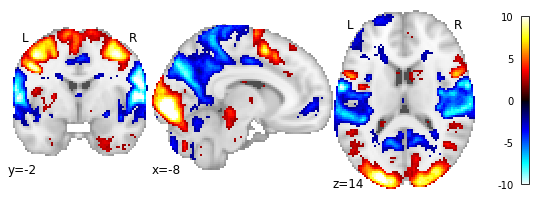

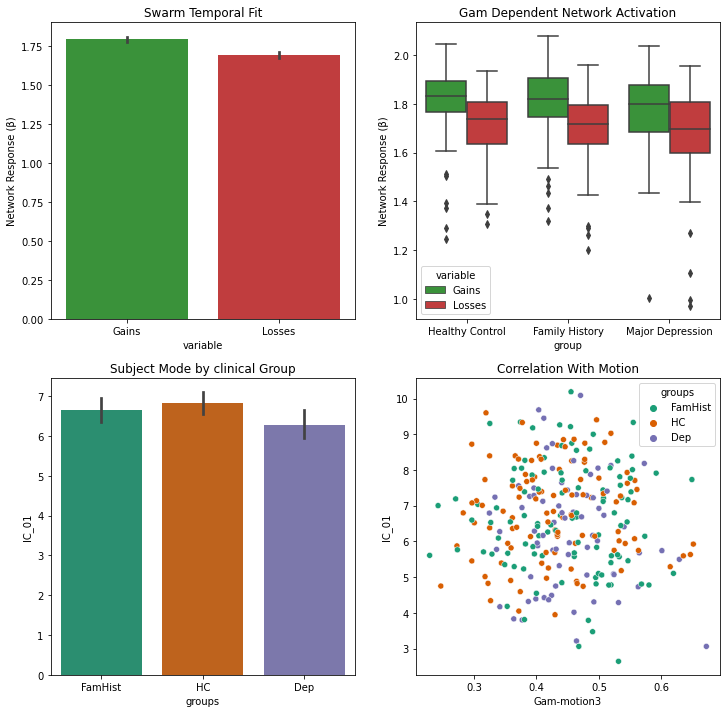

file Task     IC    stat
8   tstat_fdrp_c1.csv  Gam  IC_02  0.0001
9   tstat_uncp_c1.csv  Gam  IC_02  0.0001
10  tstat_fwep_c1.csv  Gam  IC_02  0.0001
11  tstat_fwep_c2.csv  Gam  IC_02  0.0001
12  tstat_fdrp_c2.csv  Gam  IC_02  0.0001
13       tstat_c1.csv  Gam  IC_02  8.4877
14  tstat_uncp_c2.csv  Gam  IC_02  0.0001
15       tstat_c2.csv  Gam  IC_02 -8.4877

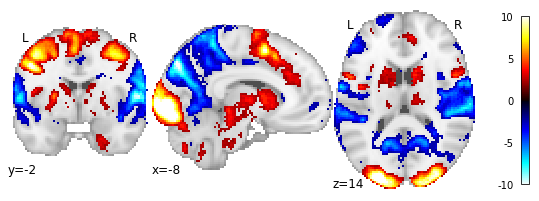

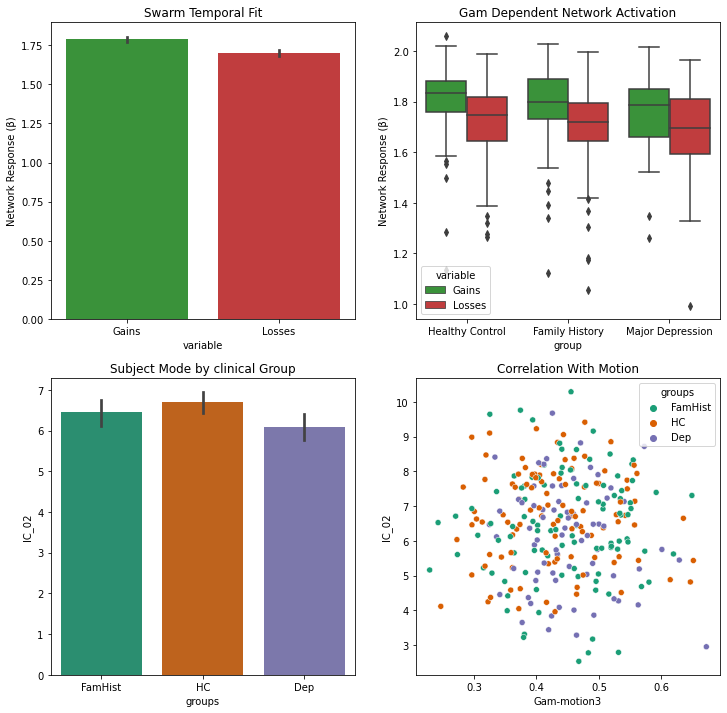

file Task     IC    stat
16  tstat_fdrp_c1.csv  Gam  IC_03  0.0001
17  tstat_uncp_c1.csv  Gam  IC_03  0.0001
18  tstat_fwep_c1.csv  Gam  IC_03  0.0001
19  tstat_fwep_c2.csv  Gam  IC_03  0.0001
20  tstat_fdrp_c2.csv  Gam  IC_03  0.0001
21       tstat_c1.csv  Gam  IC_03  7.1747
22  tstat_uncp_c2.csv  Gam  IC_03  0.0001
23       tstat_c2.csv  Gam  IC_03 -7.1747

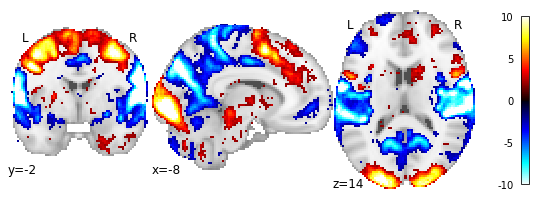

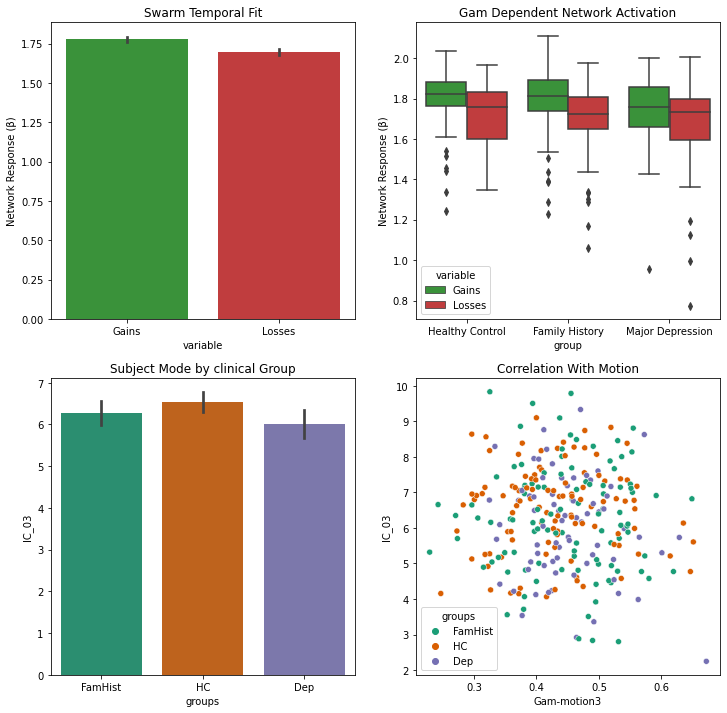

file Task     IC    stat
24  tstat_fdrp_c1.csv  Gam  IC_04  0.0001
25  tstat_uncp_c1.csv  Gam  IC_04  0.0001
26  tstat_fwep_c1.csv  Gam  IC_04  0.0001
27  tstat_fwep_c2.csv  Gam  IC_04  0.0001
28  tstat_fdrp_c2.csv  Gam  IC_04  0.0001
29       tstat_c1.csv  Gam  IC_04  8.6938
30  tstat_uncp_c2.csv  Gam  IC_04  0.0001
31       tstat_c2.csv  Gam  IC_04 -8.6938

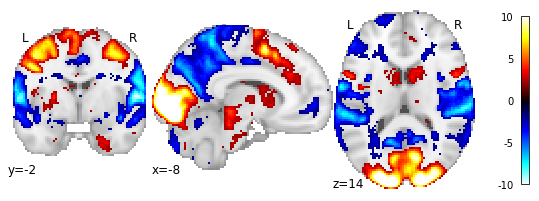

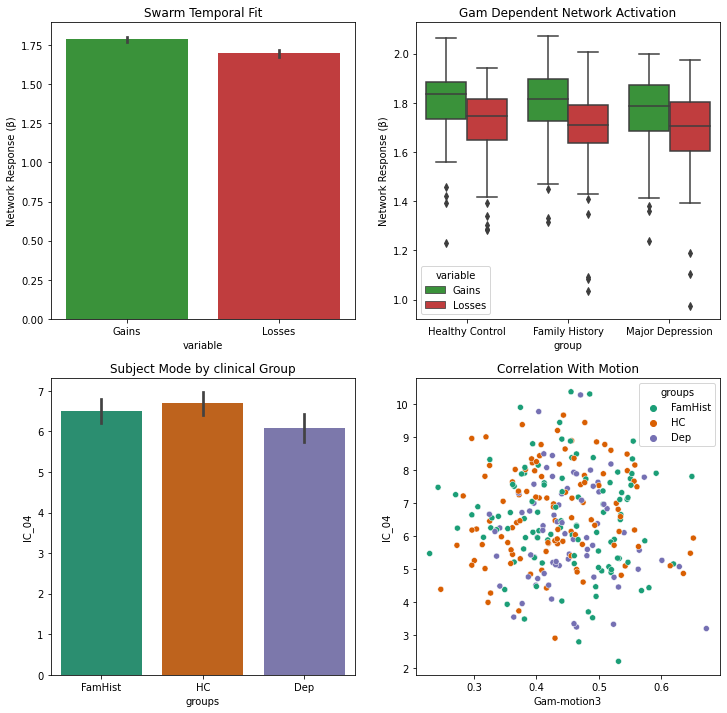

file Task     IC    stat
32  tstat_fdrp_c1.csv  Gam  IC_05  0.0001
33  tstat_uncp_c1.csv  Gam  IC_05  0.0001
34  tstat_fwep_c1.csv  Gam  IC_05  0.0001
35  tstat_fwep_c2.csv  Gam  IC_05  0.0001
36  tstat_fdrp_c2.csv  Gam  IC_05  0.0001
37       tstat_c1.csv  Gam  IC_05 -5.8424
38  tstat_uncp_c2.csv  Gam  IC_05  0.0001
39       tstat_c2.csv  Gam  IC_05  5.8424

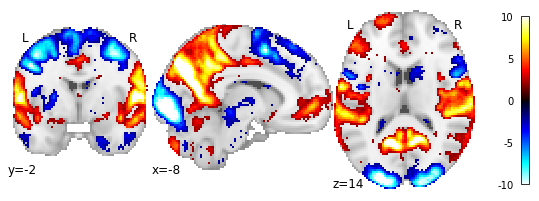

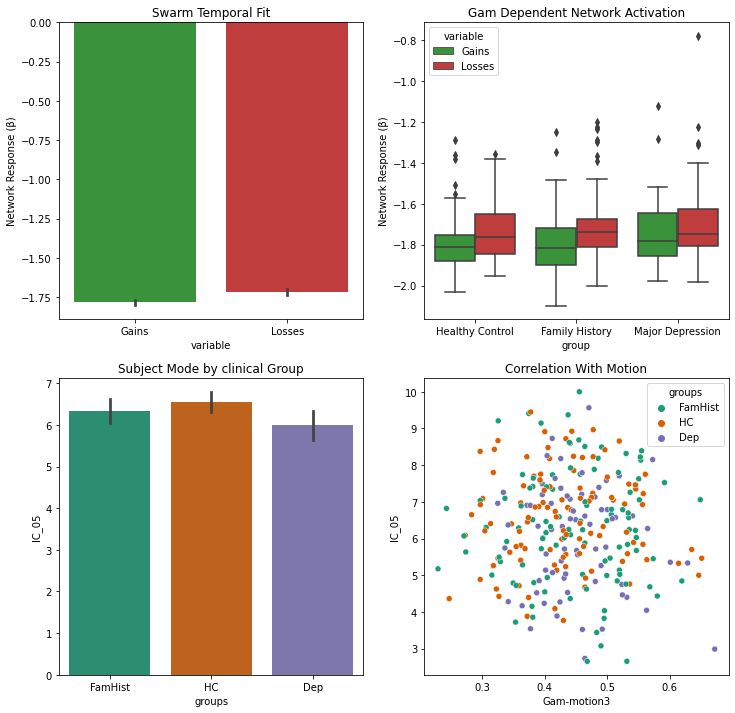

file Task     IC    stat
40  tstat_fdrp_c1.csv  Gam  IC_06  0.0003
41  tstat_uncp_c1.csv  Gam  IC_06  0.0002
42  tstat_fwep_c1.csv  Gam  IC_06  0.0002
43  tstat_fwep_c2.csv  Gam  IC_06  0.0002
44  tstat_fdrp_c2.csv  Gam  IC_06  0.0001
45       tstat_c1.csv  Gam  IC_06 -4.5019
46  tstat_uncp_c2.csv  Gam  IC_06  0.0001
47       tstat_c2.csv  Gam  IC_06  4.5019

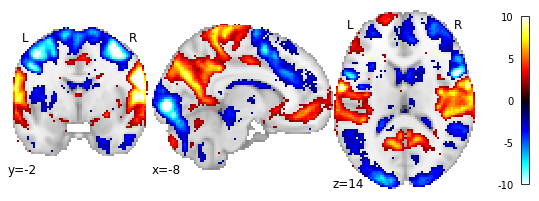

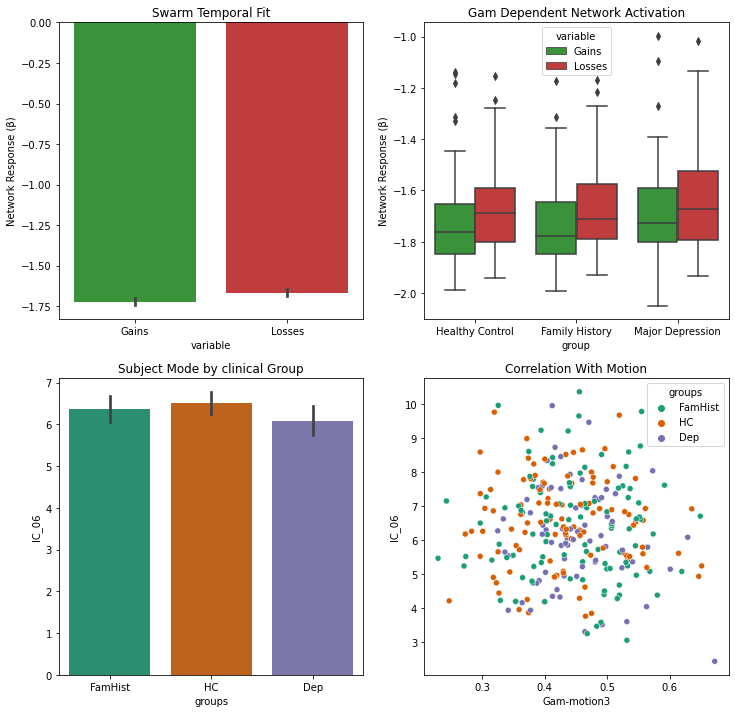

file Task     IC    stat
48  tstat_fdrp_c1.csv  Gam  IC_07  0.0001
49  tstat_uncp_c1.csv  Gam  IC_07  0.0001
50  tstat_fwep_c1.csv  Gam  IC_07  0.0001
51  tstat_fwep_c2.csv  Gam  IC_07  0.0001
52  tstat_fdrp_c2.csv  Gam  IC_07  0.0001
53       tstat_c1.csv  Gam  IC_07  6.5812
54  tstat_uncp_c2.csv  Gam  IC_07  0.0001
55       tstat_c2.csv  Gam  IC_07 -6.5812

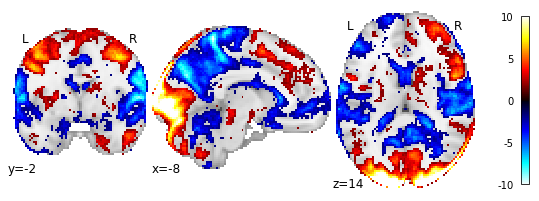

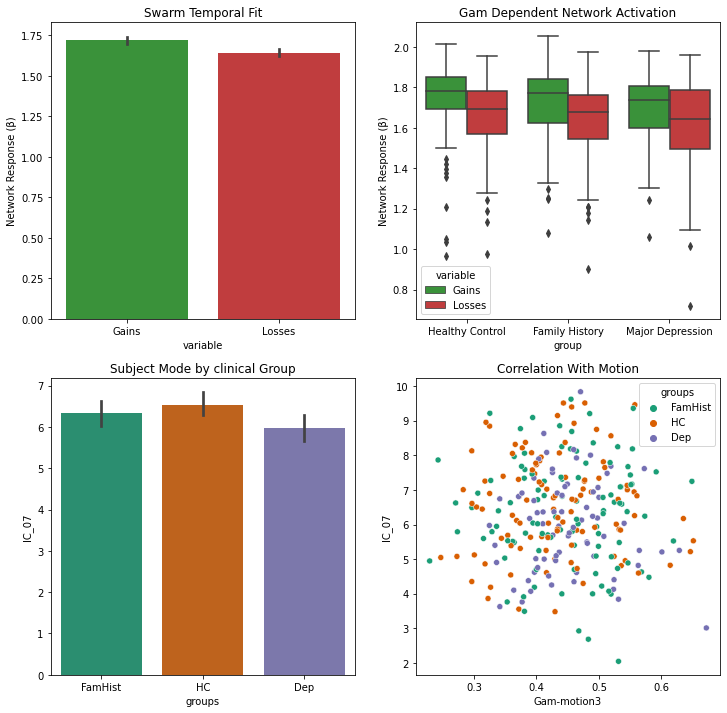

file Task     IC    stat
56  tstat_fdrp_c1.csv  Gam  IC_08  0.0001
57  tstat_uncp_c1.csv  Gam  IC_08  0.0001
58  tstat_fwep_c1.csv  Gam  IC_08  0.0001
59  tstat_fwep_c2.csv  Gam  IC_08  0.0001
60  tstat_fdrp_c2.csv  Gam  IC_08  0.0001
61       tstat_c1.csv  Gam  IC_08  6.0754
62  tstat_uncp_c2.csv  Gam  IC_08  0.0001
63       tstat_c2.csv  Gam  IC_08 -6.0754

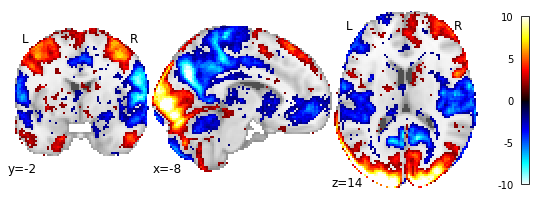

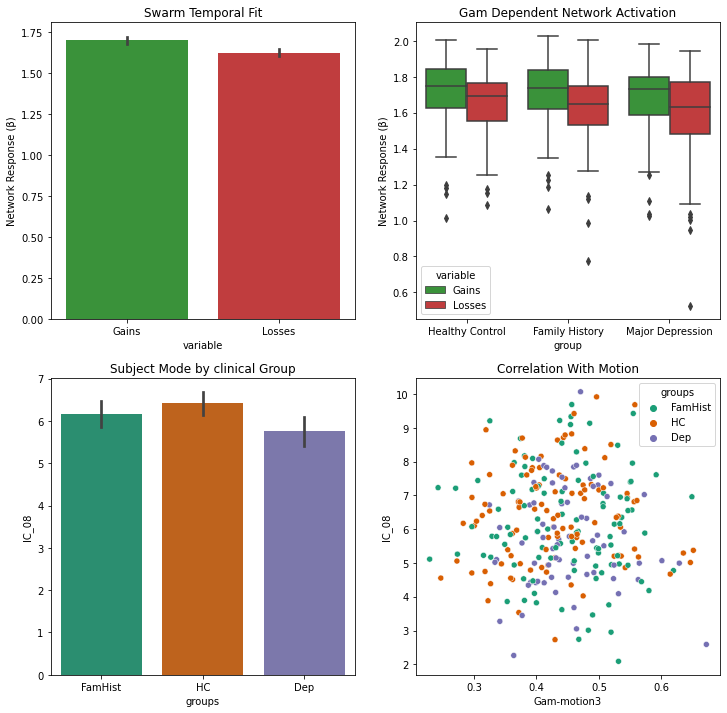

file Task     IC     stat
64  tstat_fdrp_c1.csv  Gam  IC_09   0.0001
65  tstat_uncp_c1.csv  Gam  IC_09   0.0001
66  tstat_fwep_c1.csv  Gam  IC_09   0.0001
67  tstat_fwep_c2.csv  Gam  IC_09   0.0001
68  tstat_fdrp_c2.csv  Gam  IC_09   0.0001
69       tstat_c1.csv  Gam  IC_09  10.4497
70  tstat_uncp_c2.csv  Gam  IC_09   0.0001
71       tstat_c2.csv  Gam  IC_09 -10.4497

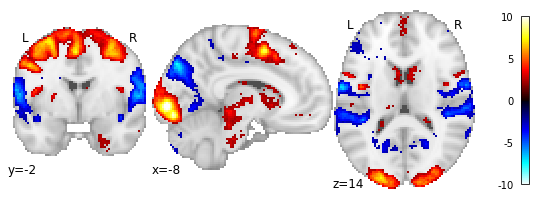

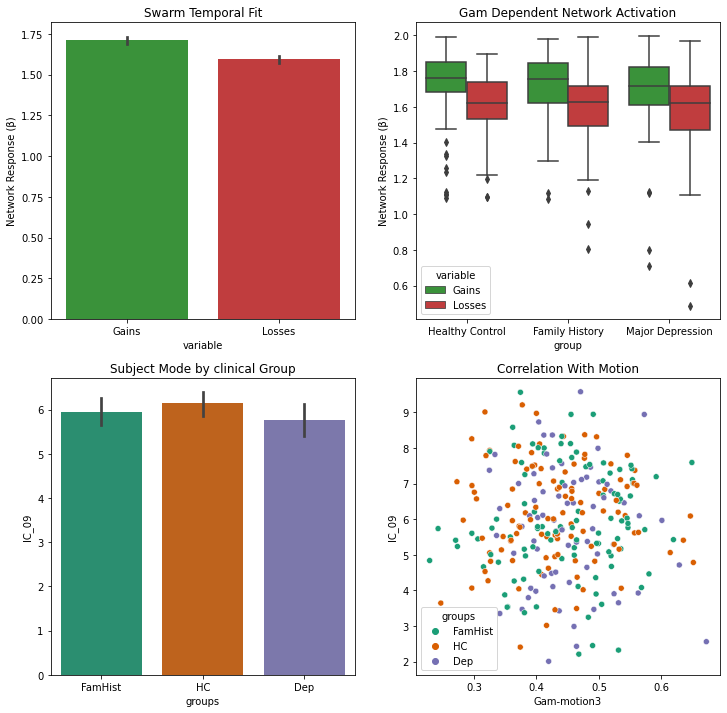

file Task     IC    stat
72  tstat_fdrp_c1.csv  Gam  IC_11  0.2597
73  tstat_uncp_c1.csv  Gam  IC_11  0.2597
74  tstat_fwep_c1.csv  Gam  IC_11  0.7981
75  tstat_fwep_c2.csv  Gam  IC_11  0.7974
76  tstat_fdrp_c2.csv  Gam  IC_11  0.2575
77       tstat_c1.csv  Gam  IC_11 -1.1238
78  tstat_uncp_c2.csv  Gam  IC_11  0.2575
79       tstat_c2.csv  Gam  IC_11  1.1238

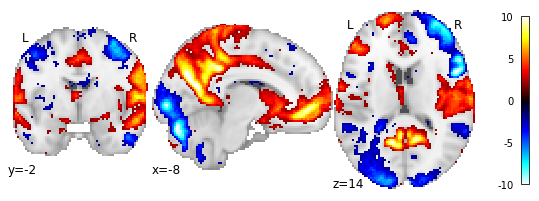

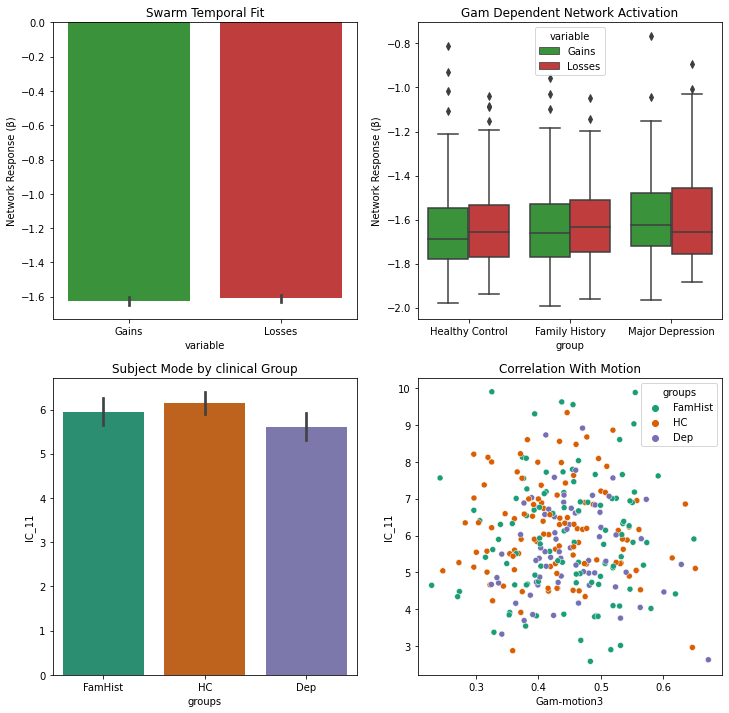

file Task     IC     stat
80  tstat_fdrp_c1.csv  Gam  IC_12   0.0001
81  tstat_uncp_c1.csv  Gam  IC_12   0.0001
82  tstat_fwep_c1.csv  Gam  IC_12   0.0001
83  tstat_fwep_c2.csv  Gam  IC_12   0.0001
84  tstat_fdrp_c2.csv  Gam  IC_12   0.0001
85       tstat_c1.csv  Gam  IC_12  10.5355
86  tstat_uncp_c2.csv  Gam  IC_12   0.0001
87       tstat_c2.csv  Gam  IC_12 -10.5355

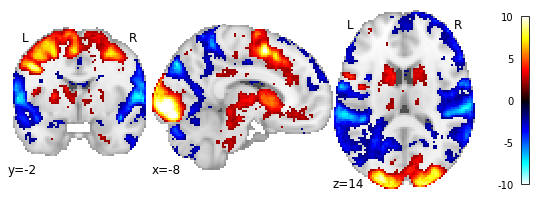

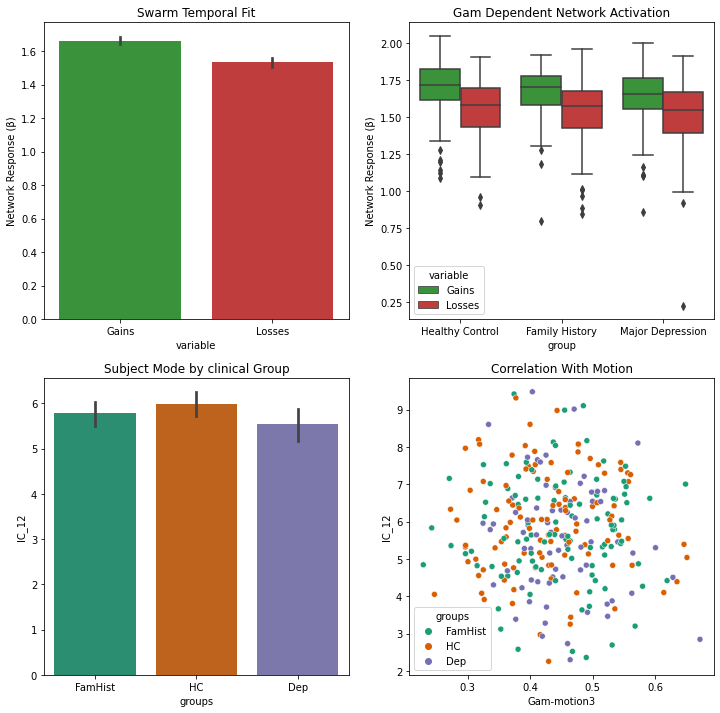

file Task     IC    stat
88  tstat_fdrp_c1.csv  Gam  IC_13  0.0001
89  tstat_uncp_c1.csv  Gam  IC_13  0.0001
90  tstat_fwep_c1.csv  Gam  IC_13  0.0001
91  tstat_fwep_c2.csv  Gam  IC_13  0.0001
92  tstat_fdrp_c2.csv  Gam  IC_13  0.0001
93       tstat_c1.csv  Gam  IC_13 -5.4479
94  tstat_uncp_c2.csv  Gam  IC_13  0.0001
95       tstat_c2.csv  Gam  IC_13  5.4479

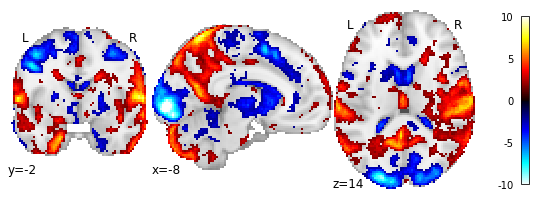

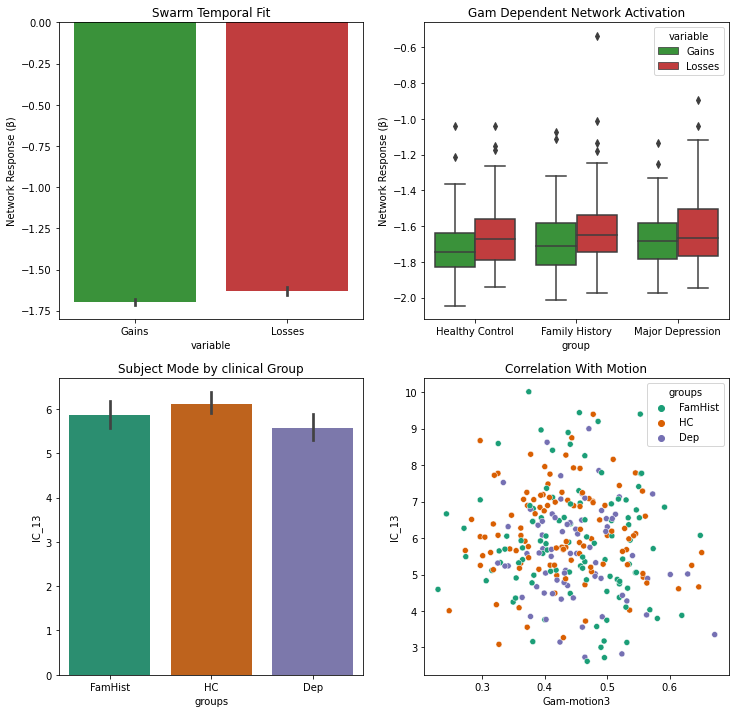

file Task     IC    stat
96   tstat_fdrp_c1.csv  Gam  IC_15  0.1890
97   tstat_uncp_c1.csv  Gam  IC_15  0.1764
98   tstat_fwep_c1.csv  Gam  IC_15  0.6386
99   tstat_fwep_c2.csv  Gam  IC_15  0.6513
100  tstat_fdrp_c2.csv  Gam  IC_15  0.1898
101       tstat_c1.csv  Gam  IC_15 -1.3522
102  tstat_uncp_c2.csv  Gam  IC_15  0.1771
103       tstat_c2.csv  Gam  IC_15  1.3522

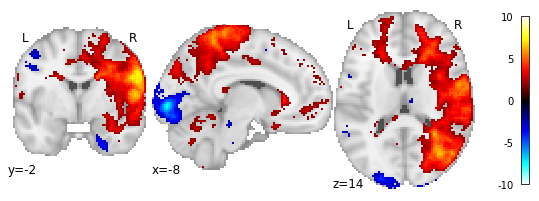

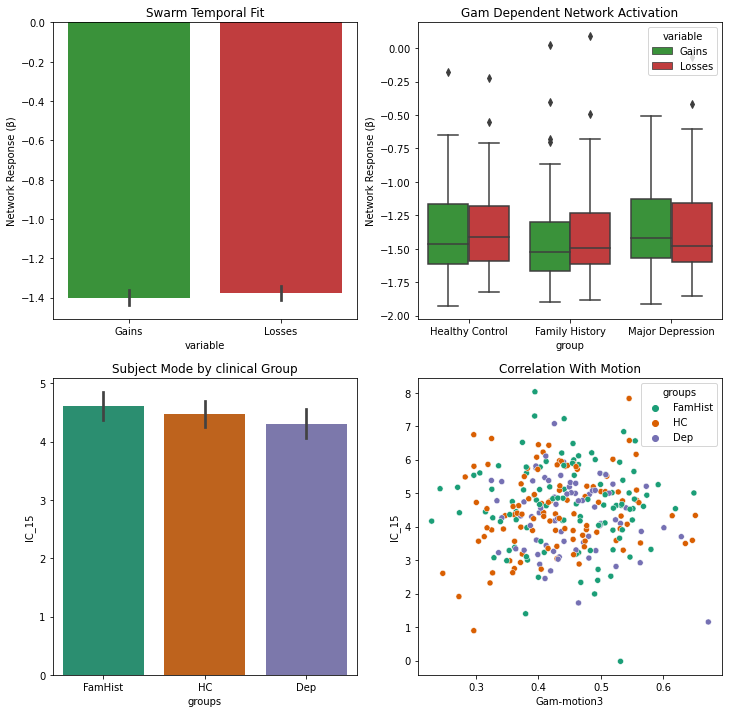

file Task     IC    stat
104  tstat_fdrp_c1.csv  Gam  IC_17  0.0525
105  tstat_uncp_c1.csv  Gam  IC_17  0.0455
106  tstat_fwep_c1.csv  Gam  IC_17  0.2591
107  tstat_fwep_c2.csv  Gam  IC_17  0.2645
108  tstat_fdrp_c2.csv  Gam  IC_17  0.0575
109       tstat_c1.csv  Gam  IC_17 -1.9706
110  tstat_uncp_c2.csv  Gam  IC_17  0.0498
111       tstat_c2.csv  Gam  IC_17  1.9706

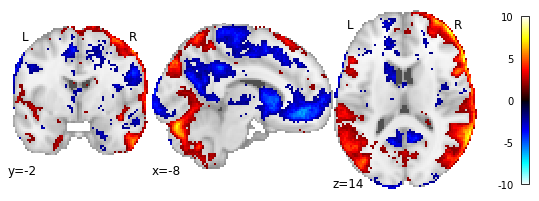

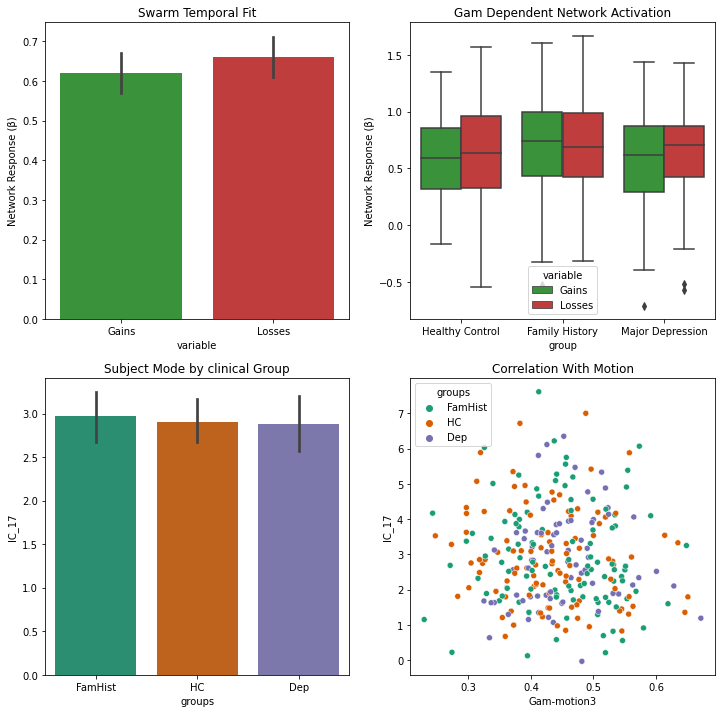

file Task     IC    stat
112  tstat_fdrp_c1.csv  Gam  IC_18  0.0001
113  tstat_uncp_c1.csv  Gam  IC_18  0.0001
114  tstat_fwep_c1.csv  Gam  IC_18  0.0001
115  tstat_fwep_c2.csv  Gam  IC_18  0.0002
116  tstat_fdrp_c2.csv  Gam  IC_18  0.0001
117       tstat_c1.csv  Gam  IC_18 -4.5397
118  tstat_uncp_c2.csv  Gam  IC_18  0.0001
119       tstat_c2.csv  Gam  IC_18  4.5397

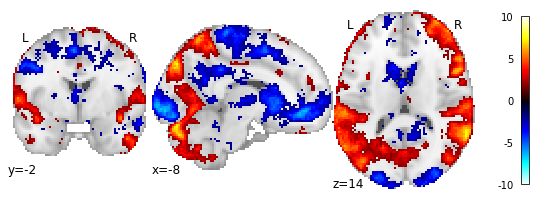

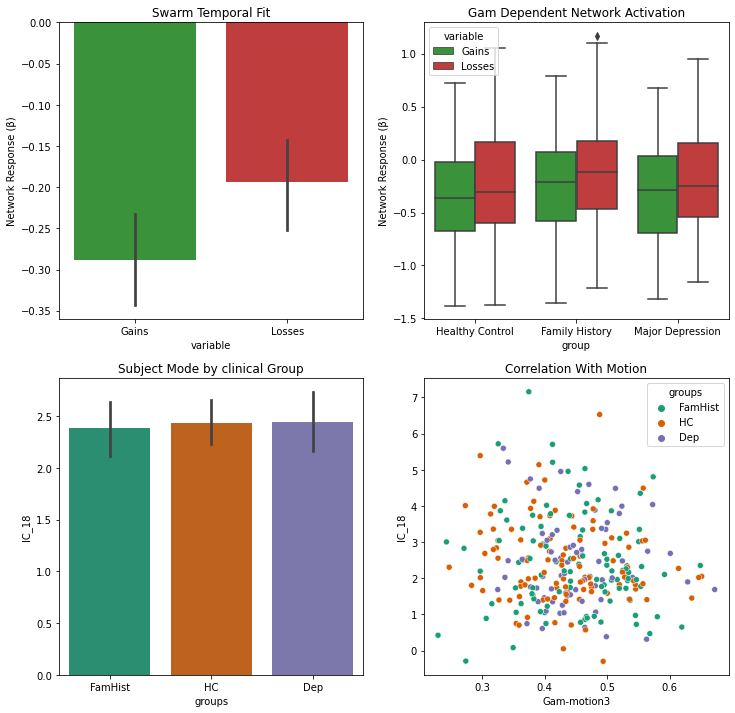

file Task     IC    stat
0  tstat_fdrp_c1.csv  Soc  IC_01  0.0001
1  tstat_uncp_c1.csv  Soc  IC_01  0.0001
2  tstat_fwep_c1.csv  Soc  IC_01  0.0001
3  tstat_fwep_c2.csv  Soc  IC_01  0.0001
4  tstat_fdrp_c2.csv  Soc  IC_01  0.0001
5       tstat_c1.csv  Soc  IC_01  6.2926
6  tstat_uncp_c2.csv  Soc  IC_01  0.0001
7       tstat_c2.csv  Soc  IC_01 -6.2926

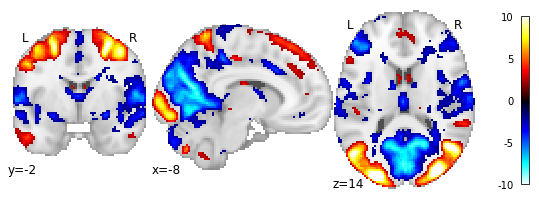

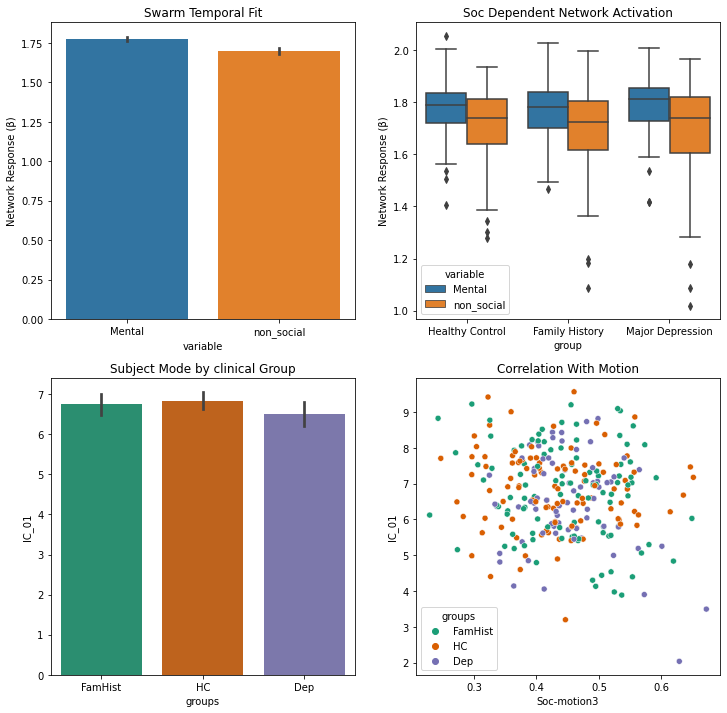

file Task     IC     stat
8   tstat_fdrp_c1.csv  Soc  IC_02   0.0001
9   tstat_uncp_c1.csv  Soc  IC_02   0.0001
10  tstat_fwep_c1.csv  Soc  IC_02   0.0001
11  tstat_fwep_c2.csv  Soc  IC_02   0.0001
12  tstat_fdrp_c2.csv  Soc  IC_02   0.0001
13       tstat_c1.csv  Soc  IC_02  22.6475
14  tstat_uncp_c2.csv  Soc  IC_02   0.0001
15       tstat_c2.csv  Soc  IC_02 -22.6475

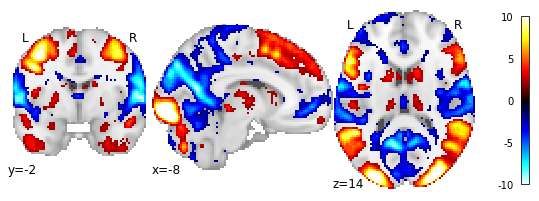

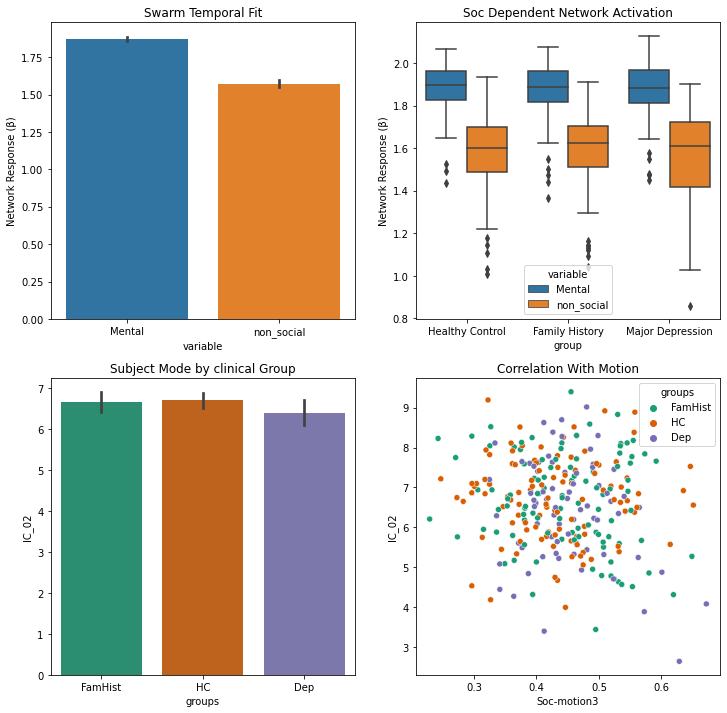

file Task     IC     stat
16  tstat_fdrp_c1.csv  Soc  IC_03   0.0001
17  tstat_uncp_c1.csv  Soc  IC_03   0.0001
18  tstat_fwep_c1.csv  Soc  IC_03   0.0001
19  tstat_fwep_c2.csv  Soc  IC_03   0.0001
20  tstat_fdrp_c2.csv  Soc  IC_03   0.0001
21       tstat_c1.csv  Soc  IC_03  34.7302
22  tstat_uncp_c2.csv  Soc  IC_03   0.0001
23       tstat_c2.csv  Soc  IC_03 -34.7302

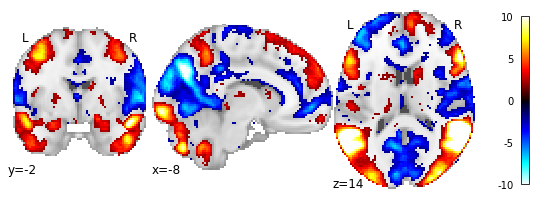

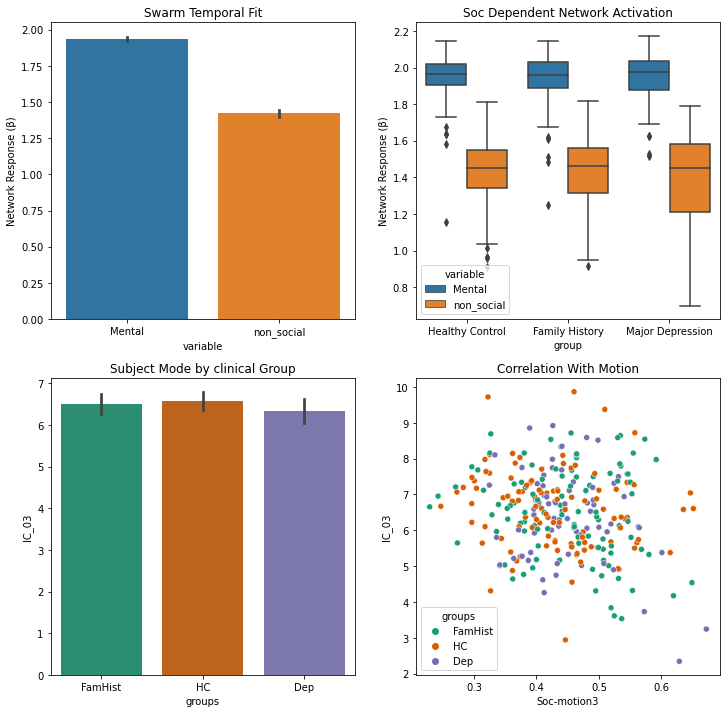

file Task     IC     stat
24  tstat_fdrp_c1.csv  Soc  IC_04   0.0001
25  tstat_uncp_c1.csv  Soc  IC_04   0.0001
26  tstat_fwep_c1.csv  Soc  IC_04   0.0001
27  tstat_fwep_c2.csv  Soc  IC_04   0.0001
28  tstat_fdrp_c2.csv  Soc  IC_04   0.0001
29       tstat_c1.csv  Soc  IC_04  13.2971
30  tstat_uncp_c2.csv  Soc  IC_04   0.0001
31       tstat_c2.csv  Soc  IC_04 -13.2971

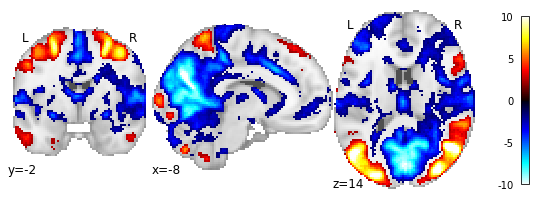

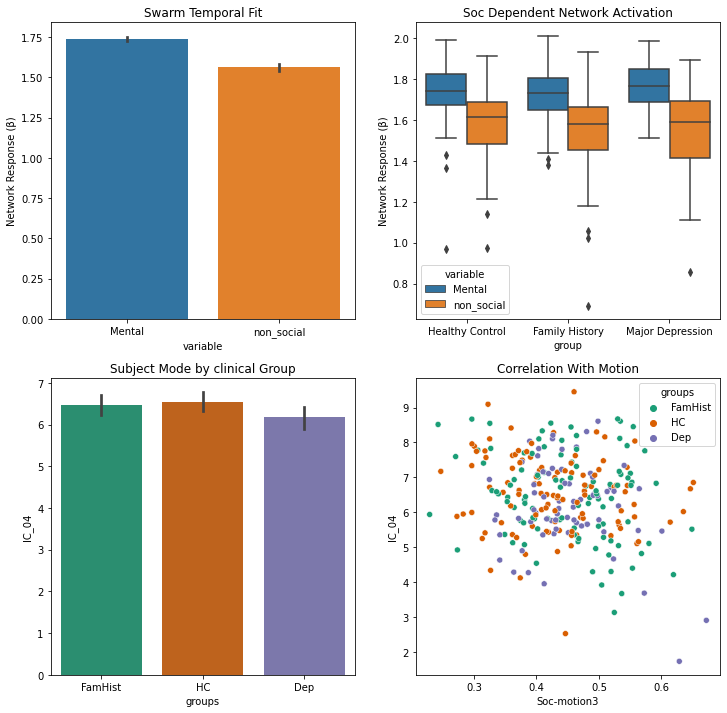

file Task     IC     stat
32  tstat_fdrp_c1.csv  Soc  IC_05   0.0001
33  tstat_uncp_c1.csv  Soc  IC_05   0.0001
34  tstat_fwep_c1.csv  Soc  IC_05   0.0001
35  tstat_fwep_c2.csv  Soc  IC_05   0.0001
36  tstat_fdrp_c2.csv  Soc  IC_05   0.0001
37       tstat_c1.csv  Soc  IC_05  30.2933
38  tstat_uncp_c2.csv  Soc  IC_05   0.0001
39       tstat_c2.csv  Soc  IC_05 -30.2933

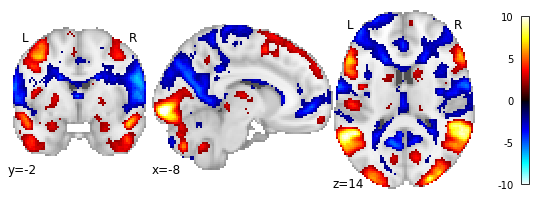

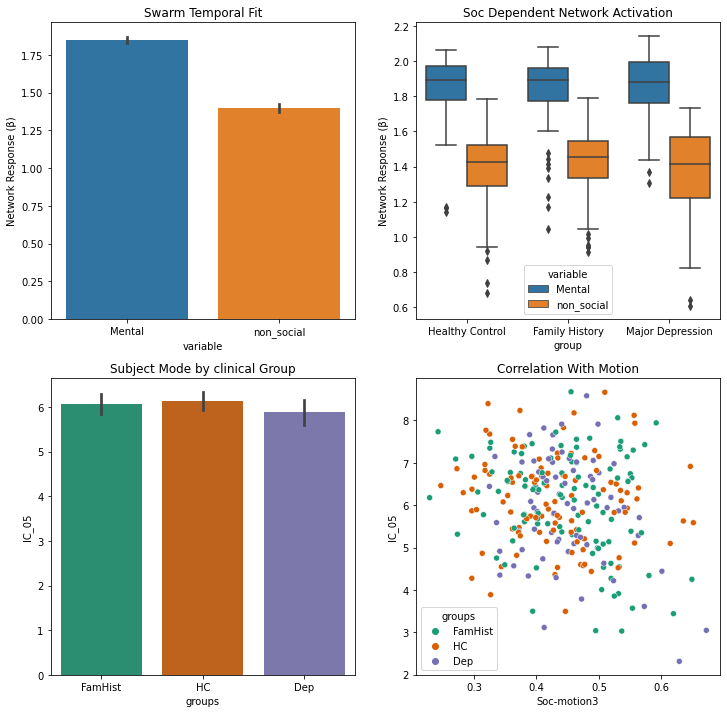

file Task     IC     stat
40  tstat_fdrp_c1.csv  Soc  IC_06   0.0001
41  tstat_uncp_c1.csv  Soc  IC_06   0.0001
42  tstat_fwep_c1.csv  Soc  IC_06   0.0001
43  tstat_fwep_c2.csv  Soc  IC_06   0.0001
44  tstat_fdrp_c2.csv  Soc  IC_06   0.0001
45       tstat_c1.csv  Soc  IC_06 -28.2512
46  tstat_uncp_c2.csv  Soc  IC_06   0.0001
47       tstat_c2.csv  Soc  IC_06  28.2512

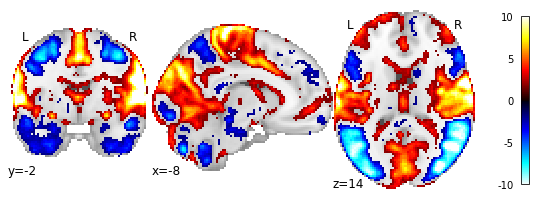

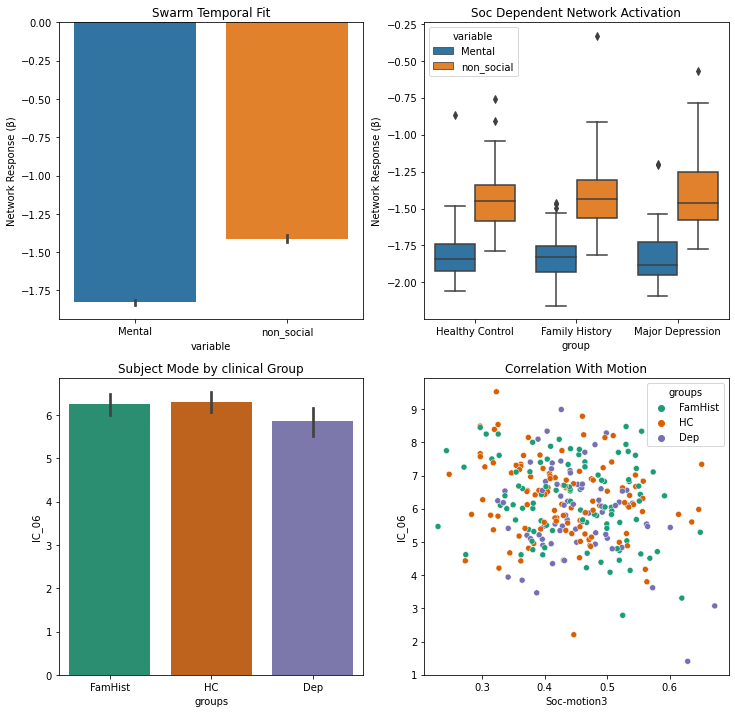

file Task     IC    stat
48  tstat_fdrp_c1.csv  Soc  IC_07  0.0001
49  tstat_uncp_c1.csv  Soc  IC_07  0.0001
50  tstat_fwep_c1.csv  Soc  IC_07  0.0001
51  tstat_fwep_c2.csv  Soc  IC_07  0.0001
52  tstat_fdrp_c2.csv  Soc  IC_07  0.0001
53       tstat_c1.csv  Soc  IC_07  6.6386
54  tstat_uncp_c2.csv  Soc  IC_07  0.0001
55       tstat_c2.csv  Soc  IC_07 -6.6386

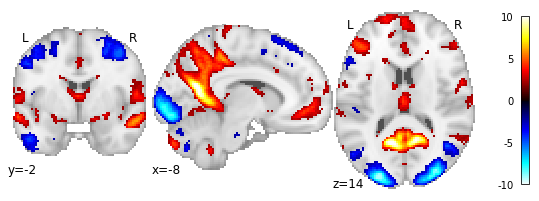

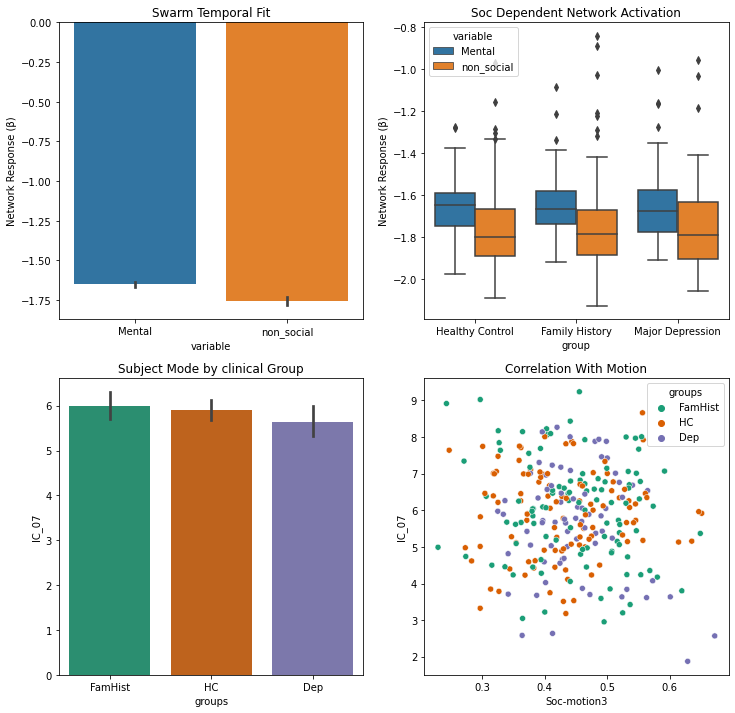

file Task     IC     stat
56  tstat_fdrp_c1.csv  Soc  IC_08   0.0001
57  tstat_uncp_c1.csv  Soc  IC_08   0.0001
58  tstat_fwep_c1.csv  Soc  IC_08   0.0001
59  tstat_fwep_c2.csv  Soc  IC_08   0.0001
60  tstat_fdrp_c2.csv  Soc  IC_08   0.0001
61       tstat_c1.csv  Soc  IC_08  25.5793
62  tstat_uncp_c2.csv  Soc  IC_08   0.0001
63       tstat_c2.csv  Soc  IC_08 -25.5793

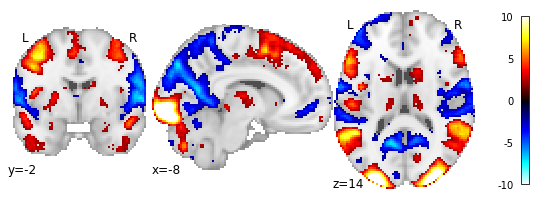

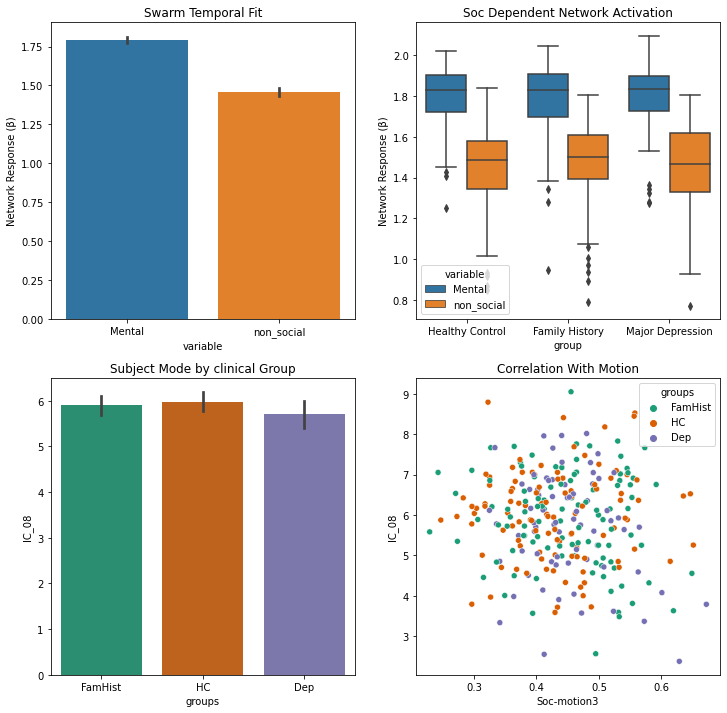

file Task     IC     stat
64  tstat_fdrp_c1.csv  Soc  IC_10   0.0001
65  tstat_uncp_c1.csv  Soc  IC_10   0.0001
66  tstat_fwep_c1.csv  Soc  IC_10   0.0001
67  tstat_fwep_c2.csv  Soc  IC_10   0.0001
68  tstat_fdrp_c2.csv  Soc  IC_10   0.0001
69       tstat_c1.csv  Soc  IC_10  13.1358
70  tstat_uncp_c2.csv  Soc  IC_10   0.0001
71       tstat_c2.csv  Soc  IC_10 -13.1358

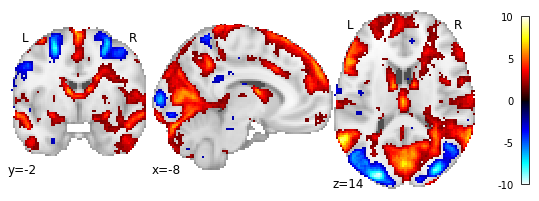

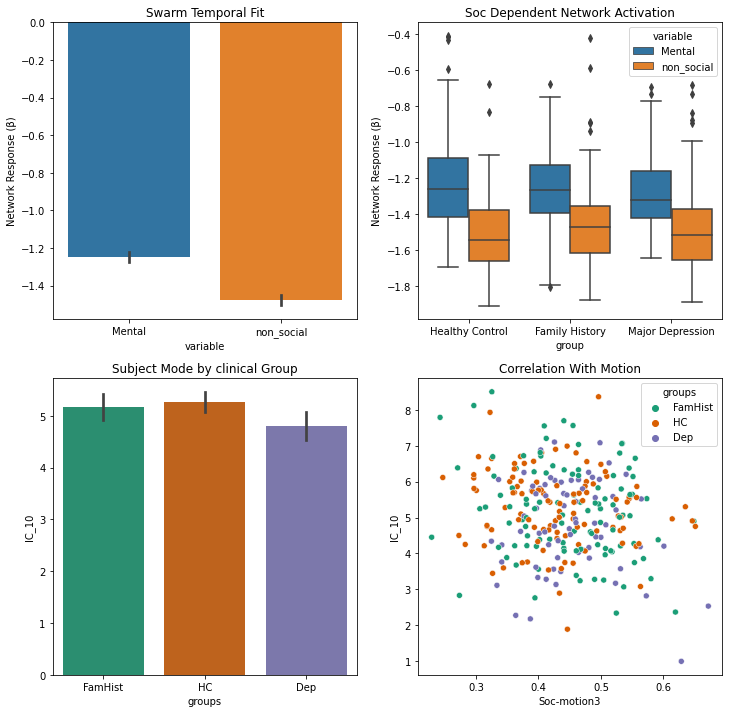

file Task     IC     stat
72  tstat_fdrp_c1.csv  Soc  IC_11   0.0001
73  tstat_uncp_c1.csv  Soc  IC_11   0.0001
74  tstat_fwep_c1.csv  Soc  IC_11   0.0001
75  tstat_fwep_c2.csv  Soc  IC_11   0.0001
76  tstat_fdrp_c2.csv  Soc  IC_11   0.0001
77       tstat_c1.csv  Soc  IC_11  10.8886
78  tstat_uncp_c2.csv  Soc  IC_11   0.0001
79       tstat_c2.csv  Soc  IC_11 -10.8886

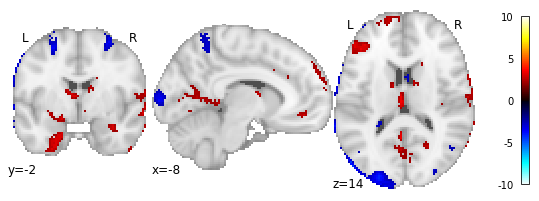

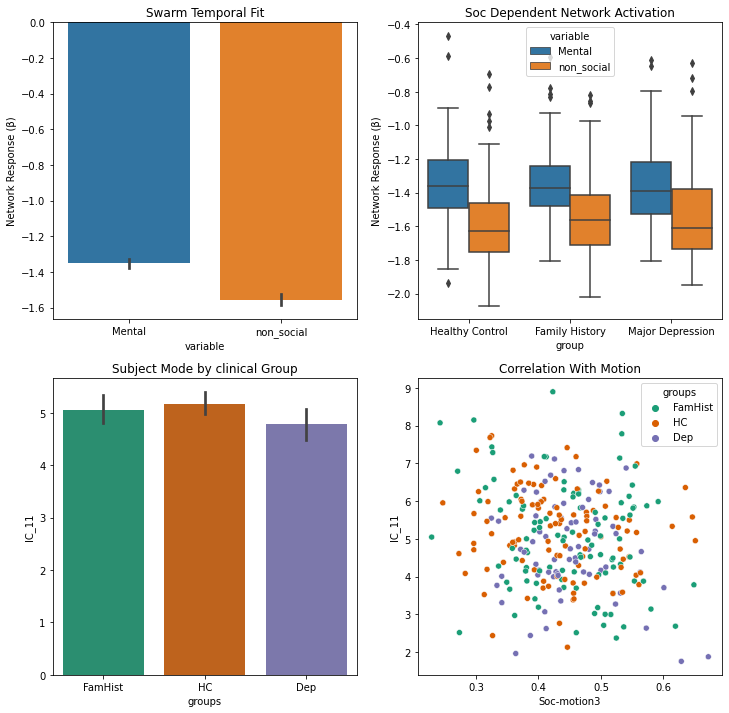

file Task     IC     stat
80  tstat_fdrp_c1.csv  Soc  IC_12   0.0001
81  tstat_uncp_c1.csv  Soc  IC_12   0.0001
82  tstat_fwep_c1.csv  Soc  IC_12   0.0001
83  tstat_fwep_c2.csv  Soc  IC_12   0.0001
84  tstat_fdrp_c2.csv  Soc  IC_12   0.0001
85       tstat_c1.csv  Soc  IC_12 -16.1499
86  tstat_uncp_c2.csv  Soc  IC_12   0.0001
87       tstat_c2.csv  Soc  IC_12  16.1499

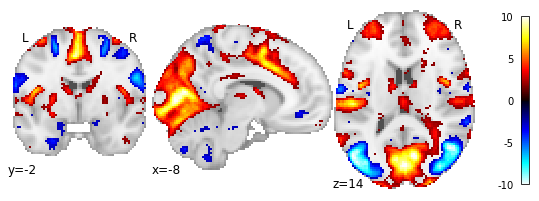

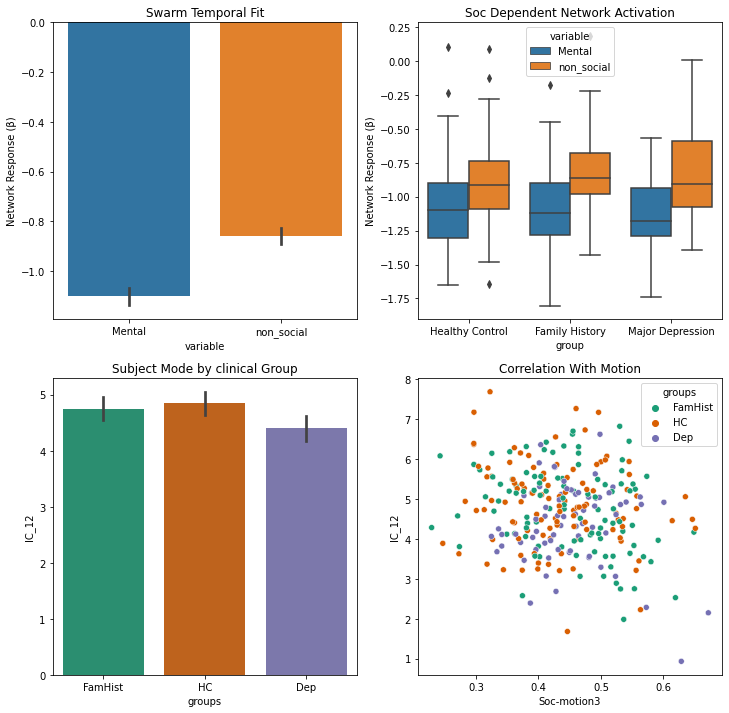

file Task     IC     stat
88  tstat_fdrp_c1.csv  Soc  IC_13   0.0001
89  tstat_uncp_c1.csv  Soc  IC_13   0.0001
90  tstat_fwep_c1.csv  Soc  IC_13   0.0001
91  tstat_fwep_c2.csv  Soc  IC_13   0.0001
92  tstat_fdrp_c2.csv  Soc  IC_13   0.0001
93       tstat_c1.csv  Soc  IC_13 -28.1153
94  tstat_uncp_c2.csv  Soc  IC_13   0.0001
95       tstat_c2.csv  Soc  IC_13  28.1153

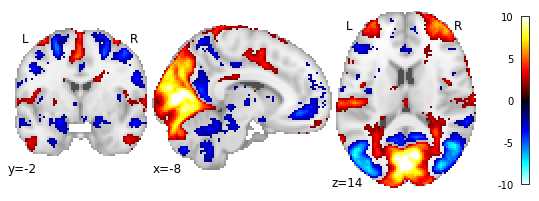

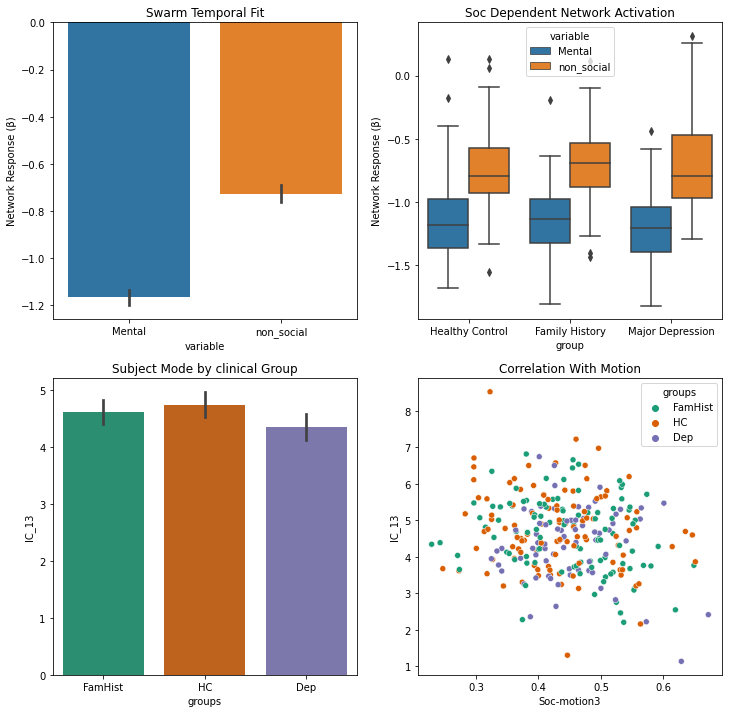

file Task     IC    stat
96   tstat_fdrp_c1.csv  Soc  IC_15  0.0001
97   tstat_uncp_c1.csv  Soc  IC_15  0.0001
98   tstat_fwep_c1.csv  Soc  IC_15  0.0010
99   tstat_fwep_c2.csv  Soc  IC_15  0.0012
100  tstat_fdrp_c2.csv  Soc  IC_15  0.0001
101       tstat_c1.csv  Soc  IC_15  3.9271
102  tstat_uncp_c2.csv  Soc  IC_15  0.0001
103       tstat_c2.csv  Soc  IC_15 -3.9271

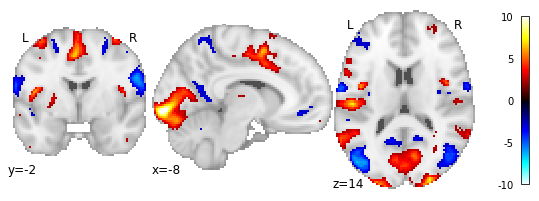

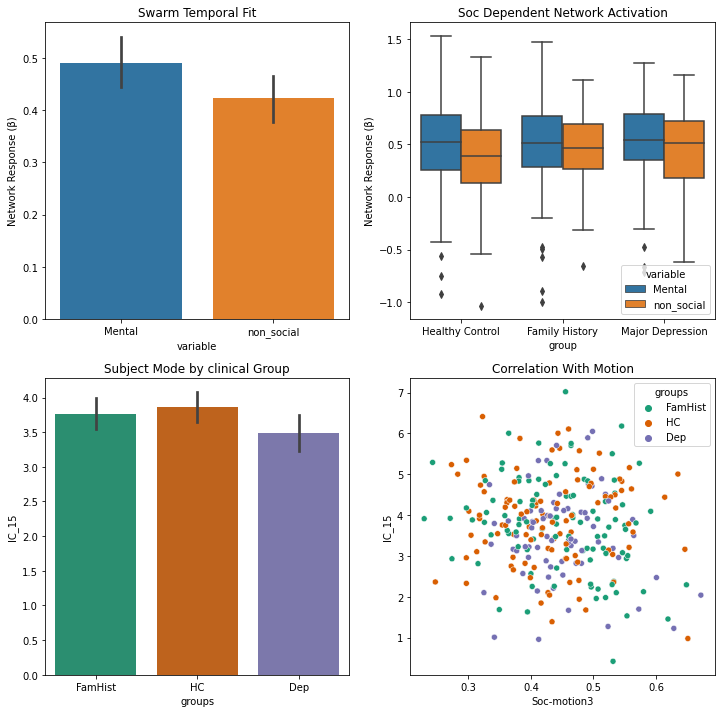

file Task     IC    stat
104  tstat_fdrp_c1.csv  Soc  IC_16  0.0001
105  tstat_uncp_c1.csv  Soc  IC_16  0.0001
106  tstat_fwep_c1.csv  Soc  IC_16  0.0001
107  tstat_fwep_c2.csv  Soc  IC_16  0.0001
108  tstat_fdrp_c2.csv  Soc  IC_16  0.0001
109       tstat_c1.csv  Soc  IC_16 -6.2733
110  tstat_uncp_c2.csv  Soc  IC_16  0.0001
111       tstat_c2.csv  Soc  IC_16  6.2733

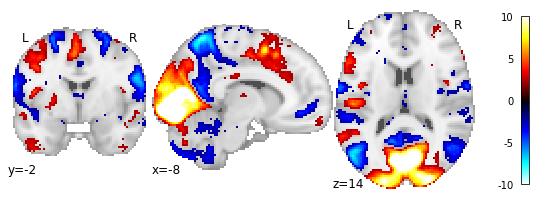

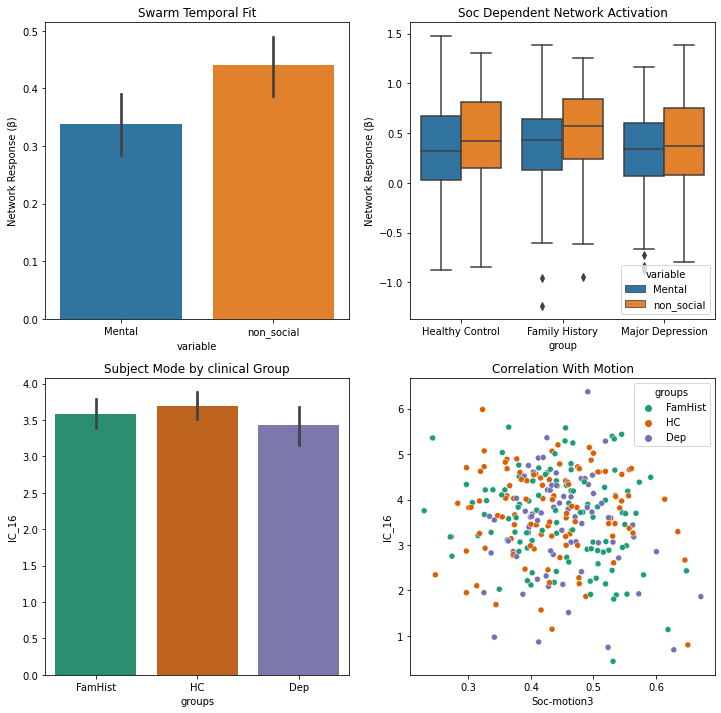

file Task     IC     stat
112  tstat_fdrp_c1.csv  Soc  IC_17   0.0001
113  tstat_uncp_c1.csv  Soc  IC_17   0.0001
114  tstat_fwep_c1.csv  Soc  IC_17   0.0001
115  tstat_fwep_c2.csv  Soc  IC_17   0.0001
116  tstat_fdrp_c2.csv  Soc  IC_17   0.0001
117       tstat_c1.csv  Soc  IC_17  16.6056
118  tstat_uncp_c2.csv  Soc  IC_17   0.0001
119       tstat_c2.csv  Soc  IC_17 -16.6056

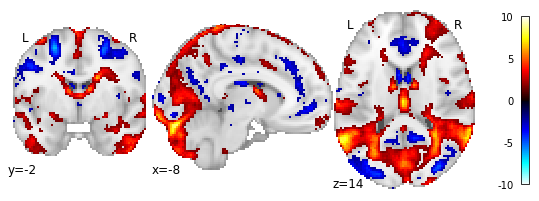

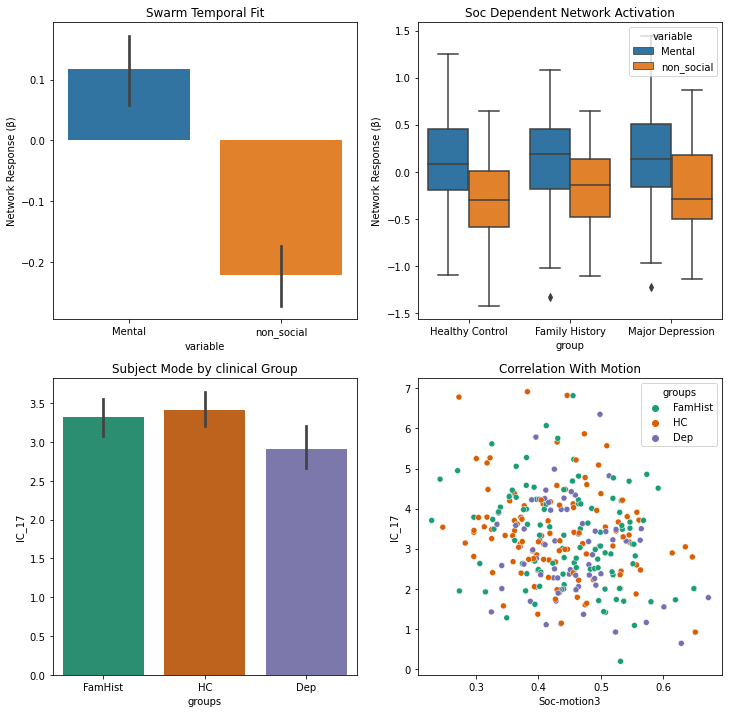

file Task     IC    stat
120  tstat_fdrp_c1.csv  Soc  IC_18  0.0001
121  tstat_uncp_c1.csv  Soc  IC_18  0.0001
122  tstat_fwep_c1.csv  Soc  IC_18  0.0001
123  tstat_fwep_c2.csv  Soc  IC_18  0.0001
124  tstat_fdrp_c2.csv  Soc  IC_18  0.0001
125       tstat_c1.csv  Soc  IC_18  5.3361
126  tstat_uncp_c2.csv  Soc  IC_18  0.0001
127       tstat_c2.csv  Soc  IC_18 -5.3361

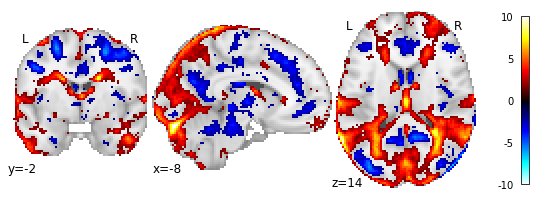

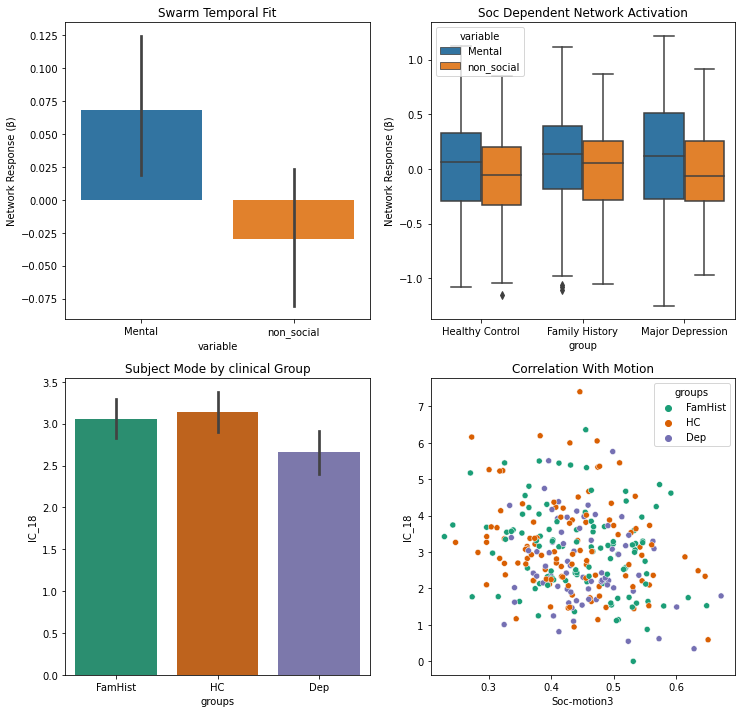

In [89]:
import matplotlib
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

import seaborn as sms

for task in palm_df['Task'].unique():
    smodes=pd.read_csv('Post-Melodic/Code/PALM/Exp1/Smode_wHeader_Exp1_task-%s_.csv'%(task))
    smodes['Subject']=subs
    stats_df=pd.merge(sub_data, smodes, on='Subject')

    
    for IC in palm_df[palm_df['Task']==task]['IC'].unique():
        display(palm_df[(palm_df['IC']==IC)&(palm_df['Task']==task)])
        plt_df=reg_df[reg_df['Task']==task].copy()
        plt_df=plt_df.drop(columns='Diff')
        plt_df = plt_df.dropna(axis=1)
        plt_df=plt_df[plt_df['IC']==IC]
        plt_df=plt_df.melt(id_vars=['sub','group','IC','Task'])
        
        if all(plt_df['Task'].isin(['Gam'])):
            pal=['tab:green','tab:red']
        else:
            pal=['tab:blue','tab:orange']

        bi=nilearn.plotting.plot_stat_map(
            hand_class[(hand_class['Task']==task)&(hand_class['IC']==IC)]['path_to_stat'].values[0],
            cut_coords=[-8,-2,14],vmax=10,draw_cross=False)
        plt.show()
        fig,((ax1, ax2),(ax3,ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(12,12))
        
        sms.barplot(x='variable',y='value',data=plt_df,ax=ax1,palette=pal)
        sms.boxplot(x='group',order=['HC','FamHist','Dep'],y='value',hue='variable',data=plt_df,ax=ax2,palette=pal)
        #sms.barplot(x='groups',y='%s'%(IC),data=stats_df,ax=ax3,ci=68)
        sms.barplot(x='groups',y='%s'%(IC),data=stats_df,ax=ax3,palette='Dark2')
        if task=='Soc':
            sms.scatterplot(x='Soc-motion3',y='%s'%(IC),data=stats_df,ax=ax4,hue='groups', palette='Dark2')
        if task=='Gam':
            sms.scatterplot(x='Gam-motion3',y='%s'%(IC),data=stats_df,ax=ax4,hue='groups', palette='Dark2')
        
        ax1.set_title("Swarm Temporal Fit")
        ax1.set_ylabel('Network Response (β)')

        ax2.set_title("%s Dependent Network Activation"%(task))
        ax2.set_ylabel('Network Response (β)')
        ax2.set_xticklabels(["Healthy Control", "Family History", "Major Depression"])
        

        ax3.set_title("Subject Mode by clinical Group")
        ax4.set_title("Correlation With Motion")

        
        if ((task=='Gam') & (IC=='IC_08'))|((task=='Soc') & (IC in ['IC_12','IC_17'])):
            fig.savefig("figures/Fig2_TaskAct_task-%s_IC-%s.svg"%(task,IC))
            bi.savefig("figures/Fig2_BrainImage_task-%s_IC-%s.svg"%(task,IC))
        plt.show()

In [13]:
len(smodes)

279

### Experiment 1: (Human Connectome)
>Look at a specific Component

sub    group     IC Task variable     value
0  sub-100206  FamHist  IC_12  Soc   Mental -0.937906
1  sub-100307  FamHist  IC_12  Soc   Mental -0.827527
2  sub-101107  FamHist  IC_12  Soc   Mental -1.336735
3  sub-101915       HC  IC_12  Soc   Mental -0.897381
4  sub-102311       HC  IC_12  Soc   Mental -0.401960

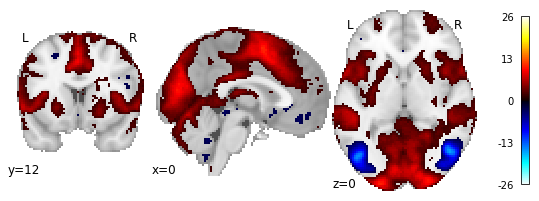

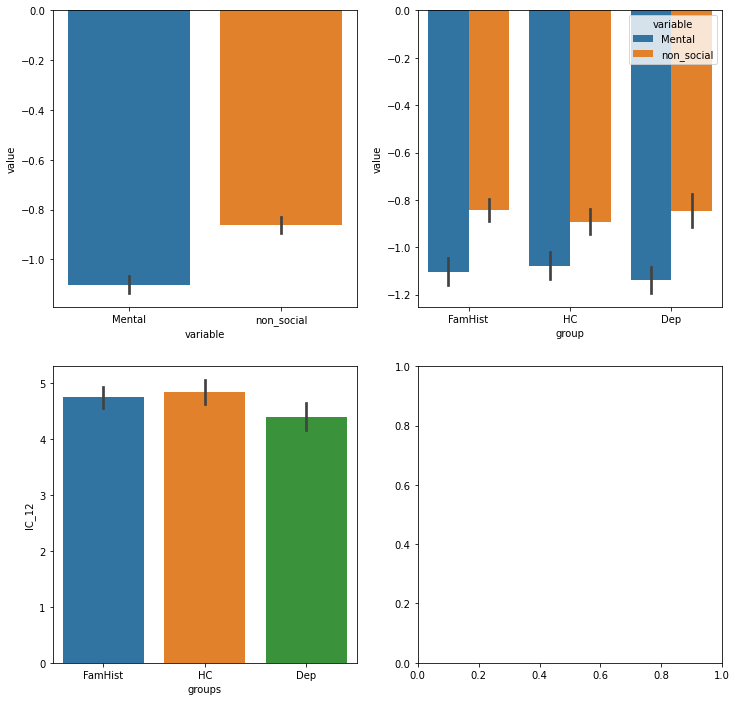

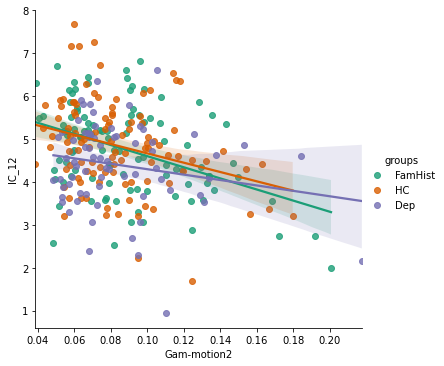

In [88]:
IC, task='IC_12', "Soc"

plt_df=reg_df[reg_df['Task']==task].copy()

plt_df=plt_df.drop(columns='Diff')
#plt_df=plt_df.drop(columns=['Mental','non_social'])
plt_df = plt_df.dropna(axis=1)
plt_df=plt_df[plt_df['IC']==IC]
plt_df=plt_df.melt(id_vars=['sub','group','IC','Task'])

display(plt_df.head())

nilearn.plotting.plot_stat_map(
    hand_class_plt[(hand_class_plt['IC']==IC)&(hand_class_plt['Task']==task)]['path_to_stat'].values[0],
    cut_coords=[0,12,0],draw_cross=False)
plt.show()
fig,((ax1, ax2),(ax3,ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(12,12))
sms.barplot(x='variable',y='value',data=plt_df,ax=ax1)
sms.barplot(x='group',y='value',hue='variable',data=plt_df,ax=ax2,ci=95)
sms.barplot(x='groups',y='%s'%(IC),data=stats_df,ax=ax3)
#sms.swarmplot(x='groups',y='%s'%(IC),data=stats_df,ax=ax3,edgecolor='black', linewidth=1)

sms.lmplot(x='Gam-motion2',y='%s'%(IC),data=stats_df,hue='groups', palette='Dark2')

plt.show()

In [81]:
from scipy.stats import ttest_ind
IC, task='IC_12',"Soc"



plt_df=reg_df[reg_df['Task']==task].copy()
plt_df = plt_df.dropna(axis=1)
plt_df=plt_df[plt_df['IC']==IC]
#plt_df=plt_df.drop(columns='Diff')
#plt_df['mean']=(plt_df['Gains']+plt_df['Losses'])/2

plt_df=plt_df.melt(id_vars=['sub','group','IC','Task'])


t_df=plt_df[plt_df['variable']=='Diff']

rvs1=t_df[t_df['group']=='HC'].value
rvs2=t_df[t_df['group']=='Dep'].value
ttest_ind(rvs1, rvs2,equal_var=False)

Ttest_indResult(statistic=2.802758832595335, pvalue=0.00575471714954639)

In [70]:
plt_df

sub    group     IC Task     Gains    Losses      mean
1953  sub-100206  FamHist  IC_08  Gam  1.958835  1.744924  1.851879
1954  sub-100307  FamHist  IC_08  Gam  1.951738  1.725303  1.838521
1955  sub-101107  FamHist  IC_08  Gam  1.415177  1.513496  1.464337
1956  sub-101915       HC  IC_08  Gam  1.895856  1.691140  1.793498
1957  sub-102311       HC  IC_08  Gam  1.732587  1.720605  1.726596
...          ...      ...    ...  ...       ...       ...       ...
2227  sub-973770       HC  IC_08  Gam  1.351829  1.293375  1.322602
2228  sub-978578      Dep  IC_08  Gam  1.535158  1.924849  1.730003
2229  sub-991267       HC  IC_08  Gam  1.702390  1.657397  1.679894
2230  sub-993675       HC  IC_08  Gam  1.541810  1.896009  1.718910
2231  sub-996782       HC  IC_08  Gam  1.824546  1.595705  1.710125

[279 rows x 7 columns]